# SETUP

## Check environment

In [1]:
USE_GPU = True

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
%matplotlib ipympl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import joblib

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from scipy.stats import pearsonr
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K
from tqdm.keras import TqdmCallback
from tensorflow.keras import optimizers

# Append the custom libraries to system path
sys.path.append("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_3_data, plot_prediction, plot_learning_curves
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction, inferenceLSTM
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData
from src.data_utils import mice
from src.time_series_utils import splitTrainValidationTestTimeSeries, reframePastFuture, padPastFuture

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(f"Tensorflow version: {tf.__version__}, GPUs: {tf.config.list_physical_devices('GPU')}")

E0000 00:00:1762140379.411226    2929 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762140379.417750    2929 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762140379.434236    2929 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762140379.434267    2929 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762140379.434269    2929 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762140379.434271    2929 computation_placer.cc:177] computation placer already registered. Please check linka

Using GPU to train
Tensorflow version: 2.19.1, GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Configuration

In [3]:
conf = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json").data
conf

{'dataset': {'aod2022': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx',
   'target_start_date': '2022-01-01',
   'target_end_date': '2022-12-31'},
  'aod2021': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv',
   'target_start_date': '2021-01-01',
   'target_end_date': '2021-12-31'},
  'mpair': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv',
   'target_start_date': '2021-01-01',
   'target_end_date': '2022-12-31',
   'station_2022_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv',
   'station_2018_2021_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.csv',
   'merged_data_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/mpair_merged.csv',
   'merged_data_dir_all_locatio

# DATA FROM VIET

## Load dataset

In [4]:
dataset_path = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"

df_raw = []

for csv_file in sorted(glob.glob(f"{dataset_path}/*")):
    print(f"Working on {csv_file}")
    df_station = pd.read_csv(csv_file)
    df_station["station"] = int(os.path.splitext(os.path.basename(csv_file))[0])
    df_raw.append(df_station)
df_raw = pd.concat(df_raw, axis=0)

# Lowercase columns name
df_raw.columns = df_raw.columns.map(lambda col: col.lower().strip())

# Set time index
df_raw["date"] = pd.to_datetime(df_raw["date"])
df_raw.set_index("date", inplace=True)

# Drop columns
features_to_use = ["pm25_quantrac", "tsp_quantrac", "station"]
df_raw = df_raw.loc[:, features_to_use]

df_raw

Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/211.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/212.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/213.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/214.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/215.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/216.csv


,pm25_quantrac,tsp_quantrac,station
date,,,
2021-02-23 21:00:00,15.604762,32.935714,211
2021-02-23 22:00:00,14.594118,30.932353,211
2021-02-23 23:00:00,13.436667,27.645000,211
2021-02-24 00:00:00,12.365000,24.380000,211
2021-02-24 01:00:00,11.636667,22.521667,211
...,...,...,...
2022-12-31 19:00:00,41.450000,107.451667,216
2022-12-31 20:00:00,50.530000,126.168333,216
2022-12-31 21:00:00,55.055000,139.688333,216


## Data preparation

### Drop missing

In [5]:
df = []
for station in sorted(df_raw["station"].unique()):
    df_station = df_raw[df_raw["station"] == station]
    df.append(df_station.dropna())
df = pd.concat(df, axis=0)
df

,pm25_quantrac,tsp_quantrac,station
date,,,
2021-02-23 21:00:00,15.604762,32.935714,211
2021-02-23 22:00:00,14.594118,30.932353,211
2021-02-23 23:00:00,13.436667,27.645000,211
2021-02-24 00:00:00,12.365000,24.380000,211
2021-02-24 01:00:00,11.636667,22.521667,211
...,...,...,...
2022-12-31 19:00:00,41.450000,107.451667,216
2022-12-31 20:00:00,50.530000,126.168333,216
2022-12-31 21:00:00,55.055000,139.688333,216


### Feature engineering

In [6]:
# Apply sin/cos to hour
k = 24
df["sintime"] = np.sin(2 * np.pi * (df.index.hour / k))
df["costime"] = np.cos(2 * np.pi * (df.index.hour / k))

# Convert station to one-hot vector
onehot = OneHotEncoder(sparse_output=False)
onehot_encoded_location = pd.DataFrame(onehot.fit_transform(df[["station"]]), columns=df["station"].unique(), index=df.index)
df = pd.concat([df, onehot_encoded_location], axis=1)
df = df.drop(columns=["station"])
df

,pm25_quantrac,tsp_quantrac,sintime,costime,211,212,213,214,215,216
date,,,,,,,,,,
2021-02-23 21:00:00,15.604762,32.935714,-0.707107,0.707107,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-23 22:00:00,14.594118,30.932353,-0.500000,0.866025,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-23 23:00:00,13.436667,27.645000,-0.258819,0.965926,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-24 00:00:00,12.365000,24.380000,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-24 01:00:00,11.636667,22.521667,0.258819,0.965926,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,41.450000,107.451667,-0.965926,0.258819,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-31 20:00:00,50.530000,126.168333,-0.866025,0.500000,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-31 21:00:00,55.055000,139.688333,-0.707107,0.707107,0.0,0.0,0.0,0.0,0.0,1.0


### Scale

In [7]:
df_scaled = copy.deepcopy(df)

# Scale features
features_to_scale = ["tsp_quantrac"]
for f in features_to_scale:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[f]])
    df_scaled[f] = scaled_data

# Scale label
label = "pm25_quantrac"
label_scaler = MinMaxScaler()
df_scaled[label] = label_scaler.fit_transform(df[[label]])

df_scaled

,pm25_quantrac,tsp_quantrac,sintime,costime,211,212,213,214,215,216
date,,,,,,,,,,
2021-02-23 21:00:00,0.096032,0.091311,-0.707107,0.707107,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-23 22:00:00,0.089813,0.085757,-0.500000,0.866025,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-23 23:00:00,0.082690,0.076643,-0.258819,0.965926,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-24 00:00:00,0.076095,0.067591,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-24 01:00:00,0.071612,0.062439,0.258819,0.965926,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.255085,0.297899,-0.965926,0.258819,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-31 20:00:00,0.310963,0.349789,-0.866025,0.500000,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-31 21:00:00,0.338810,0.387272,-0.707107,0.707107,0.0,0.0,0.0,0.0,0.0,1.0


### Train test split

In [8]:
splitter = round(0.8 * len(df_scaled))
train_data = df_scaled.iloc[:splitter]
test_data = df_scaled.iloc[splitter:]

display(train_data)
display(test_data)

,pm25_quantrac,tsp_quantrac,sintime,costime,211,212,213,214,215,216
date,,,,,,,,,,
2021-02-23 21:00:00,0.096032,0.091311,-0.707107,7.071068e-01,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-23 22:00:00,0.089813,0.085757,-0.500000,8.660254e-01,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-23 23:00:00,0.082690,0.076643,-0.258819,9.659258e-01,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-24 00:00:00,0.076095,0.067591,0.000000,1.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-24 01:00:00,0.071612,0.062439,0.258819,9.659258e-01,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-09-21 06:00:00,0.059110,0.052214,1.000000,6.123234e-17,0.0,0.0,0.0,0.0,0.0,1.0
2021-09-21 07:00:00,0.065058,0.058590,0.965926,-2.588190e-01,0.0,0.0,0.0,0.0,0.0,1.0
2021-09-21 08:00:00,0.067930,0.060540,0.866025,-5.000000e-01,0.0,0.0,0.0,0.0,0.0,1.0


,pm25_quantrac,tsp_quantrac,sintime,costime,211,212,213,214,215,216
date,,,,,,,,,,
2021-09-21 11:00:00,0.065315,0.057731,2.588190e-01,-0.965926,0.0,0.0,0.0,0.0,0.0,1.0
2021-09-21 12:00:00,0.059551,0.050703,1.224647e-16,-1.000000,0.0,0.0,0.0,0.0,0.0,1.0
2021-09-21 13:00:00,0.058597,0.048018,-2.588190e-01,-0.965926,0.0,0.0,0.0,0.0,0.0,1.0
2021-09-21 14:00:00,0.053520,0.039493,-5.000000e-01,-0.866025,0.0,0.0,0.0,0.0,0.0,1.0
2021-09-21 15:00:00,0.064546,0.053170,-7.071068e-01,-0.707107,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.255085,0.297899,-9.659258e-01,0.258819,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-31 20:00:00,0.310963,0.349789,-8.660254e-01,0.500000,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-31 21:00:00,0.338810,0.387272,-7.071068e-01,0.707107,0.0,0.0,0.0,0.0,0.0,1.0


## Prediction

### Model paramaters

In [9]:
n_past = 168
n_future = 4
n_label = 1
latent_dim = 32

epochs = 200
batch_size = 128

In [10]:
# Calculate MNBE
def mean_normalized_bias_error(y_pred, y_actual):
    y_pred = np.array(y_pred)
    y_actual = np.array(y_actual)
    return np.mean((y_pred - y_actual) / np.mean(y_actual)) * 100

metrics_calculators = {
    "mae": mean_absolute_error,
    "mse": mean_squared_error,
    "rmse": root_mean_squared_error,
    "r2": r2_score,
    "mape": mean_absolute_percentage_error,
    "mnbe": mean_normalized_bias_error,
    "r_coeff": lambda a,b: pearsonr(a, b)[0]
}

### Reframe data

In [11]:
# Function to reframe data
def reframe(data, n_past, n_future, n_shifted=0):
    m = np.arange(0, len(data) - n_past - n_future - n_shifted + 1)
    X = np.array([data.iloc[i:(i + n_past), :] for i in m])
    label_col_index = 0
    y = np.expand_dims(np.array([data.iloc[(i + n_shifted + n_past):(i + n_shifted + n_past + n_future), label_col_index] for i in m]), -1)
    return X, y

X_train, y_train = reframe(train_data, n_past, n_future)
X_test, y_test = reframe(test_data, n_past, n_future)

X_train_shifted_1, y_train_shifted_1 = reframe(train_data, n_past, n_future, 1)
X_test_shifted_1, y_test_shifted_1 = reframe(test_data, n_past, n_future, 1)
print(X_train_shifted_1.shape, y_train_shifted_1.shape, X_test_shifted_1.shape, y_test_shifted_1.shape)

X_train_shifted_2, y_train_shifted_2 = reframe(train_data, n_past, n_future, 2)
X_test_shifted_2, y_test_shifted_2 = reframe(test_data, n_past, n_future, 2)
print(X_train_shifted_2.shape, y_train_shifted_2.shape, X_test_shifted_2.shape, y_test_shifted_2.shape)

X_train_shifted_3, y_train_shifted_3 = reframe(train_data, n_past, n_future, 3)
X_test_shifted_3, y_test_shifted_3 = reframe(test_data, n_past, n_future, 3)
print(X_train_shifted_3.shape, y_train_shifted_3.shape, X_test_shifted_3.shape, y_test_shifted_3.shape)

X_train_shifted_4, y_train_shifted_4 = reframe(train_data, n_past, n_future, 4)
X_test_shifted_4, y_test_shifted_4 = reframe(test_data, n_past, n_future, 4)
print(X_train_shifted_4.shape, y_train_shifted_4.shape, X_test_shifted_4.shape, y_test_shifted_4.shape)

(39766, 168, 10) (39766, 4, 1) (9813, 168, 10) (9813, 4, 1)
(39765, 168, 10) (39765, 4, 1) (9812, 168, 10) (9812, 4, 1)
(39764, 168, 10) (39764, 4, 1) (9811, 168, 10) (9811, 4, 1)
(39763, 168, 10) (39763, 4, 1) (9810, 168, 10) (9810, 4, 1)


### LSTM-Seq2Seq

In [12]:
def define_lstms2s_model(n_past, n_future, n_features, n_label, name="model"):
    # Encoder layers
    encoder_inputs = Input(shape=(n_past, n_features))
    encoder_lstm_1 = LSTM(128, return_sequences=True, activation="relu")(encoder_inputs)
    encoder_lstm_2, state_h, state_c = LSTM(64, return_state=True, activation="relu", dropout=0.2)(encoder_lstm_1)
    encoder_dense = Dense(latent_dim)(encoder_lstm_2)
    # Repeat layer
    decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
    # Decoder layers
    decoder_lstm_1 = LSTM(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=[state_h, state_c])
    decoder_lstm_2 = LSTM(128, return_sequences=True, activation="relu", dropout=0.2)(decoder_lstm_1)
    decoder_outputs = TimeDistributed(Dense(n_label))(decoder_lstm_2)

    # Compile the model
    model = Model(encoder_inputs, decoder_outputs)
    model.name = name
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
    display(model.summary())
    return model

#### No shift

I0000 00:00:1762140444.217361    2929 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0


Model: "lstms2s_no_shift"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 168, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 168, 128)  │     71,168 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 64),      │     49,408 │ lstm[0][0]        │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 4, 32)     │          0 │ dense[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 4, 64)     │     24,832 │ repeat_vector[0]… │
│                     │                   │            │ lstm_1[0][1],     │
│                     │                   │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 4, 128)    │     98,816 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 4, 1)      │        129 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 246,433 (962.63 KB)

 Trainable params: 246,433 (962.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200


I0000 00:00:1762140450.348800    3015 service.cc:152] XLA service 0x61e52d04cfe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762140450.348837    3015 service.cc:160]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1762140451.456711    3015 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762140468.111548    3015 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 2/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0047 - val_loss: 0.0015
Epoch 3/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 4/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 5/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 6/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


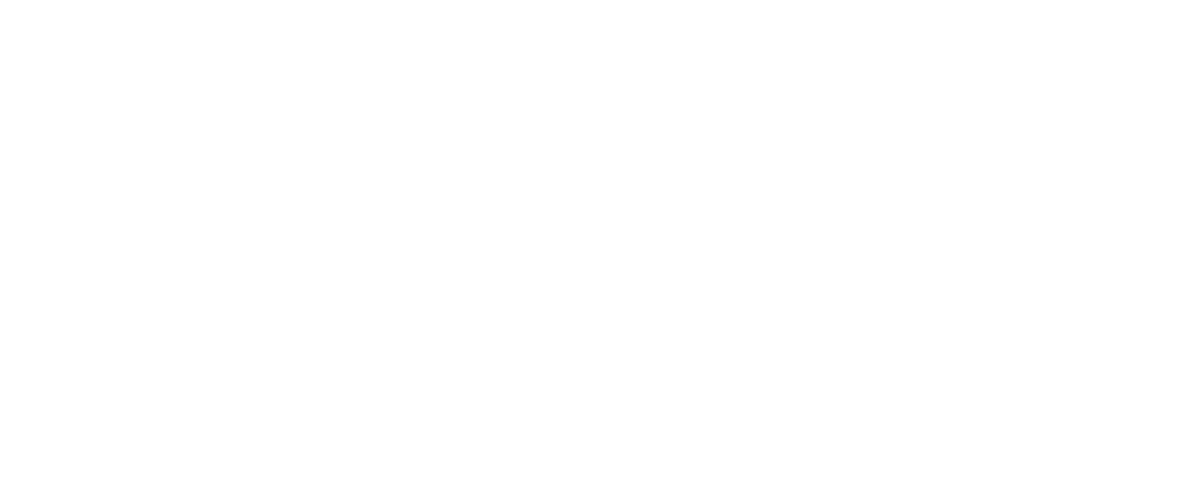

307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
Day = 0
mae: 6.659158275660922
mse: 91.93144992898358
rmse: 9.588088961257274
r2: -647.2203226315308
mape: 0.46124466048938767
mnbe: -25.5575034221682
r_coeff: [0.31164712]


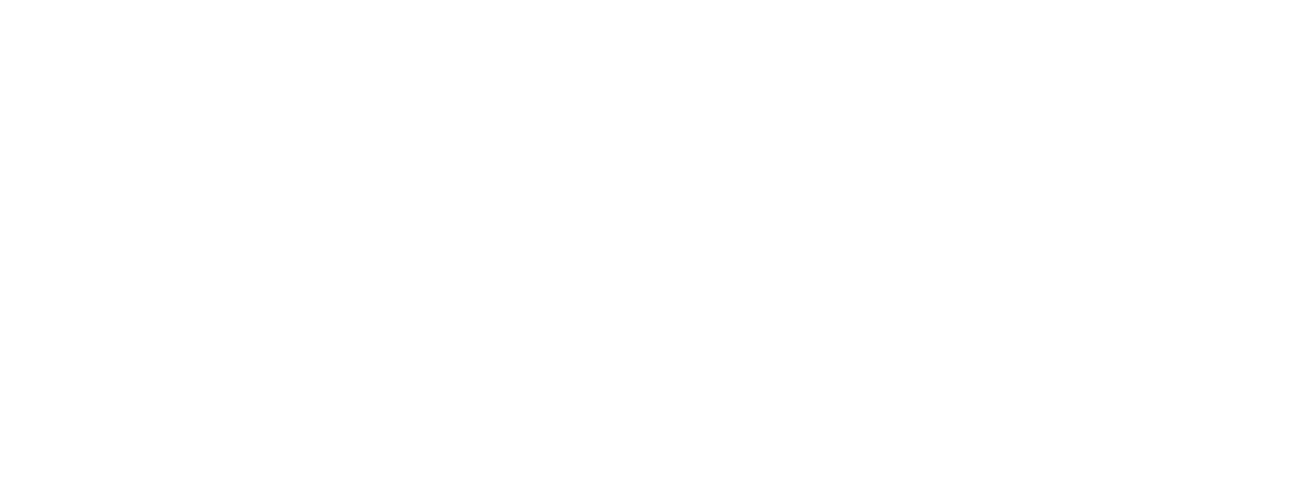

Day = 1
mae: 6.529475134233313
mse: 88.5251130793906
rmse: 9.408778511549233
r2: -677.7710965880938
mape: 0.44097427268154715
mnbe: -23.596471559394665
r_coeff: [0.29502252]


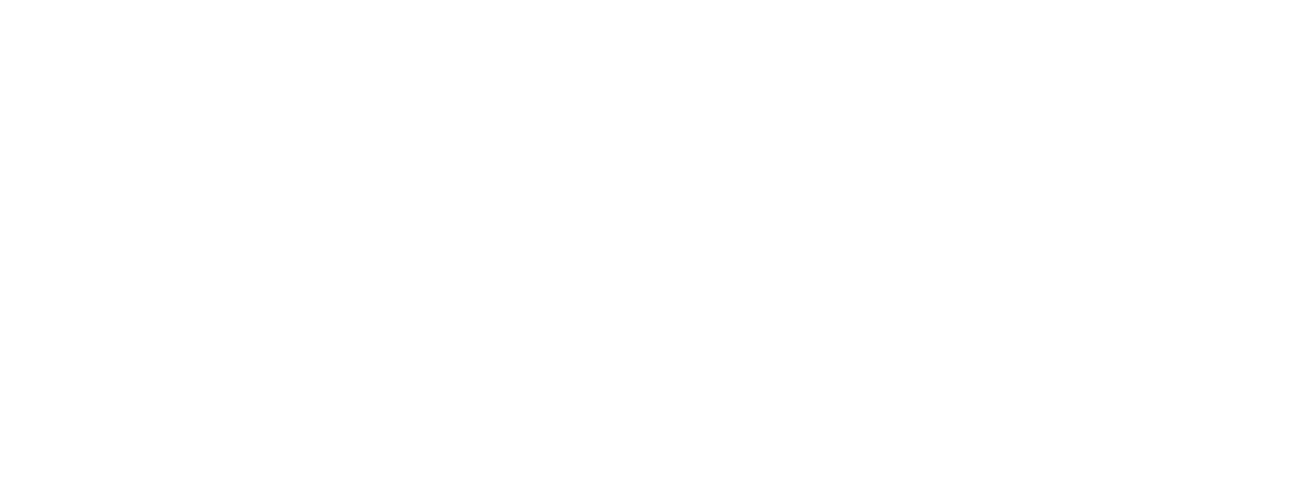

Day = 2
mae: 6.741214568881377
mse: 94.07349298435142
rmse: 9.699149085582272
r2: -1058.6251499974346
mape: 0.47297310348642885
mnbe: -26.382240844340664
r_coeff: [0.2736484]


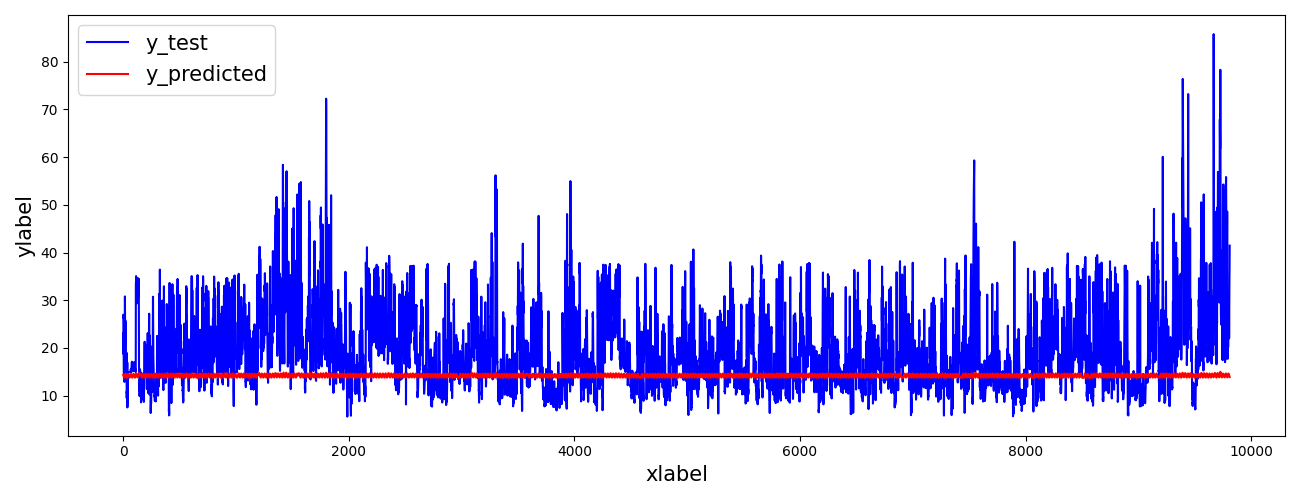

Day = 3
mae: 7.019267105349601
mse: 101.00235409609122
rmse: 10.049992741096444
r2: -1958.134064509303
mape: 0.515115619520532
mnbe: -29.533886020607014
r_coeff: [0.24783966]


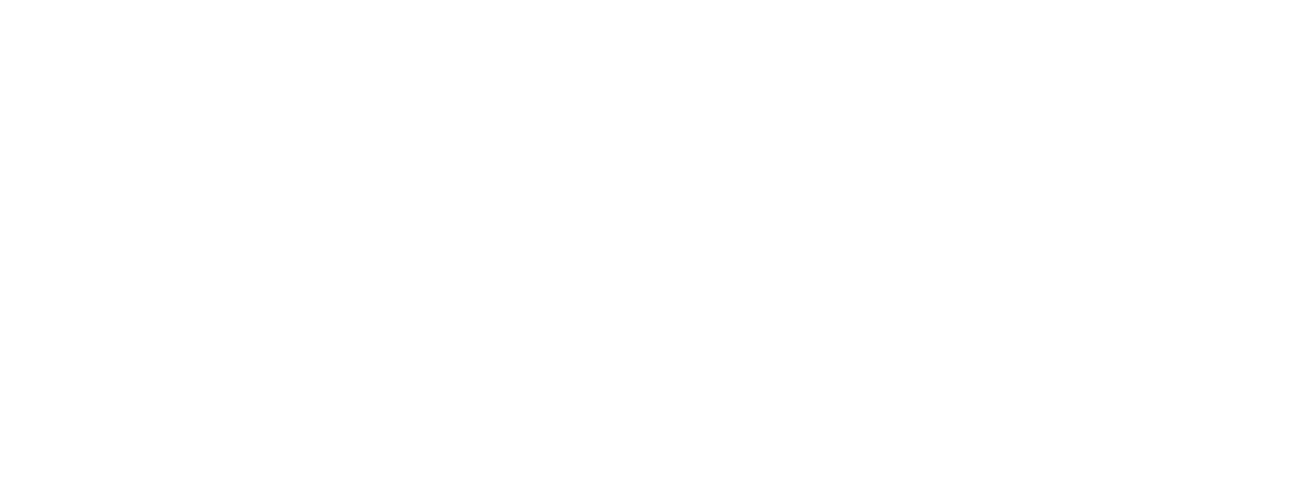

In [13]:
lstms2s = define_lstms2s_model(n_past, n_future, X_train.shape[-1], y_train.shape[-1], "lstms2s_no_shift")

history = lstms2s.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = lstms2s.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 1

Model: "lstms2s_shifted_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 168, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 168, 128)  │     71,168 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 64),      │     49,408 │ lstm_4[0][0]      │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 4, 32)     │          0 │ dense_2[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 4, 64)     │     24,832 │ repeat_vector_1[… │
│                     │                   │            │ lstm_5[0][1],     │
│                     │                   │            │ lstm_5[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 4, 128)    │     98,816 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 4, 1)      │        129 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 246,433 (962.63 KB)

 Trainable params: 246,433 (962.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - loss: 0.0054 - val_loss: 0.0014
Epoch 2/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 3/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 4/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 5/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 6/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


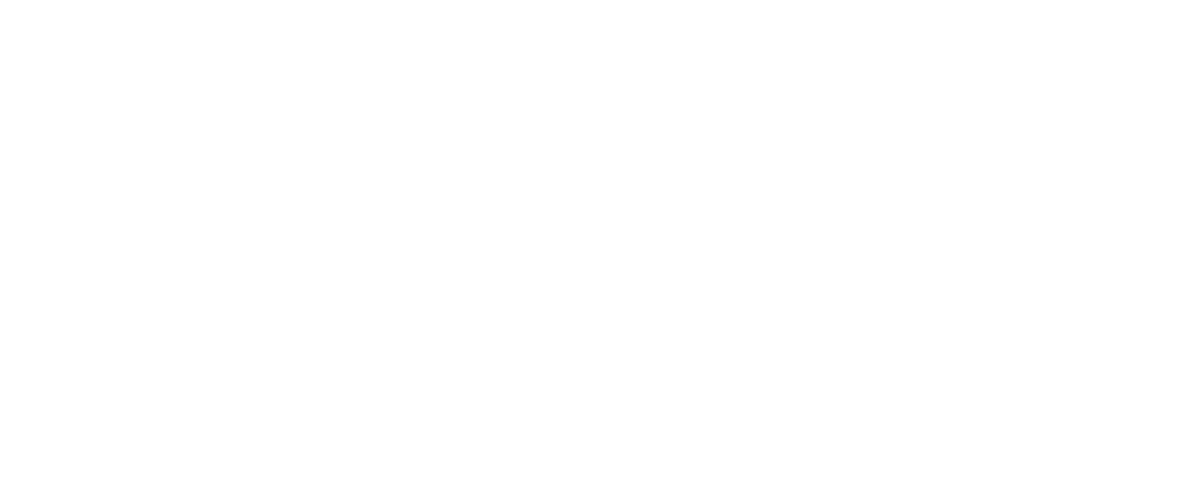

307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step
Day = 0
mae: 6.243721002969473
mse: 80.52094904168862
rmse: 8.973346590970875
r2: -154.8408911586951
mape: 0.3966860285021992
mnbe: -18.62763903395094
r_coeff: [0.19806653]


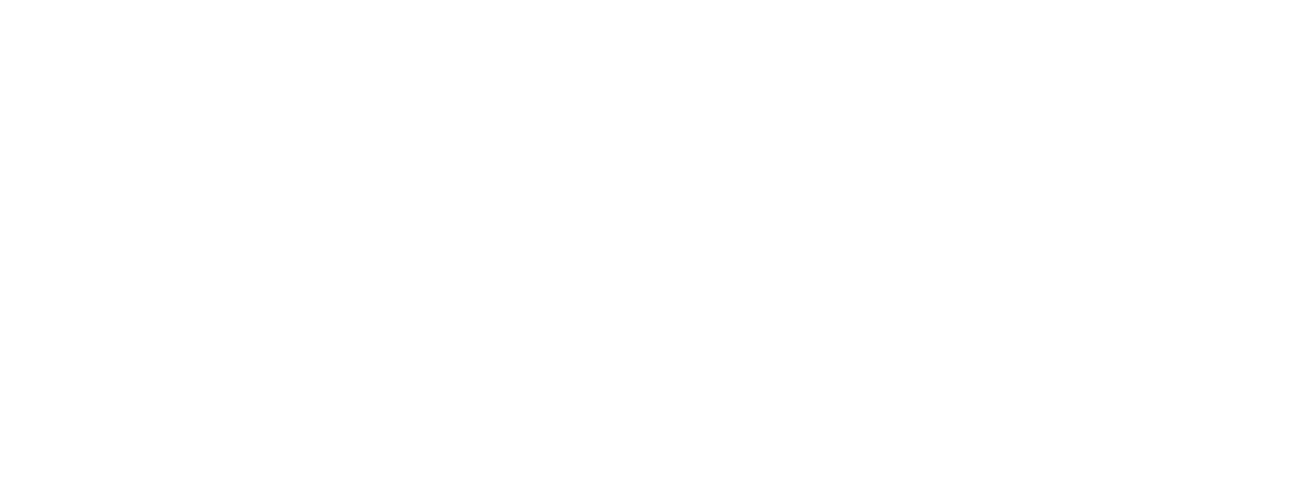

Day = 1
mae: 6.147593897515103
mse: 76.94077603736241
rmse: 8.77158913979459
r2: -124.35982407516993
mape: 0.3775728961567191
mnbe: -15.75104901027253
r_coeff: [0.18222338]


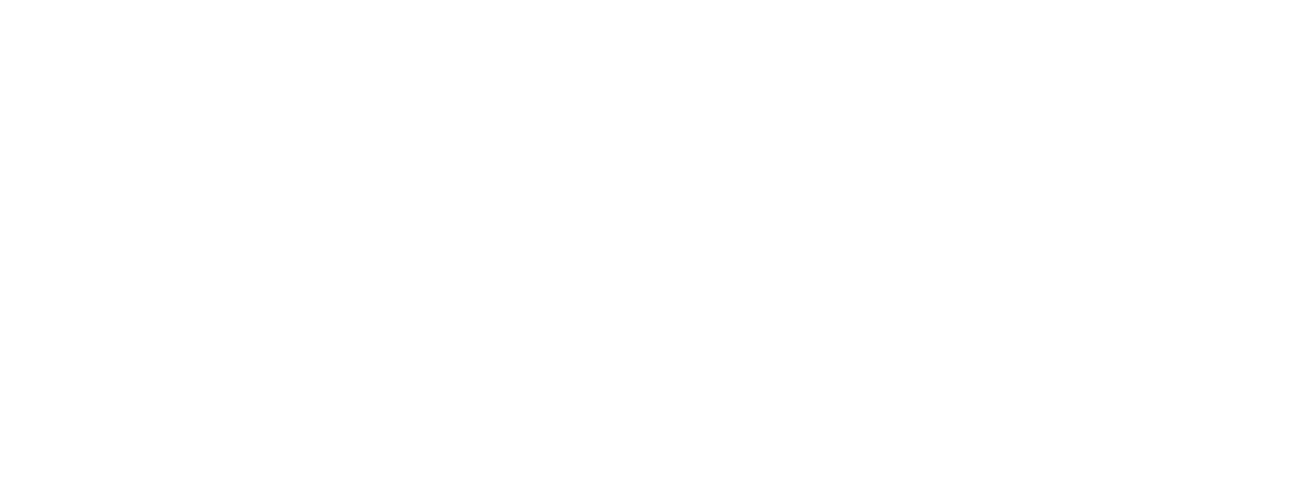

Day = 2
mae: 6.237399173532525
mse: 80.25802759063573
rmse: 8.958684478796858
r2: -161.41600917960582
mape: 0.3946123754831989
mnbe: -18.190448386311072
r_coeff: [0.1723081]


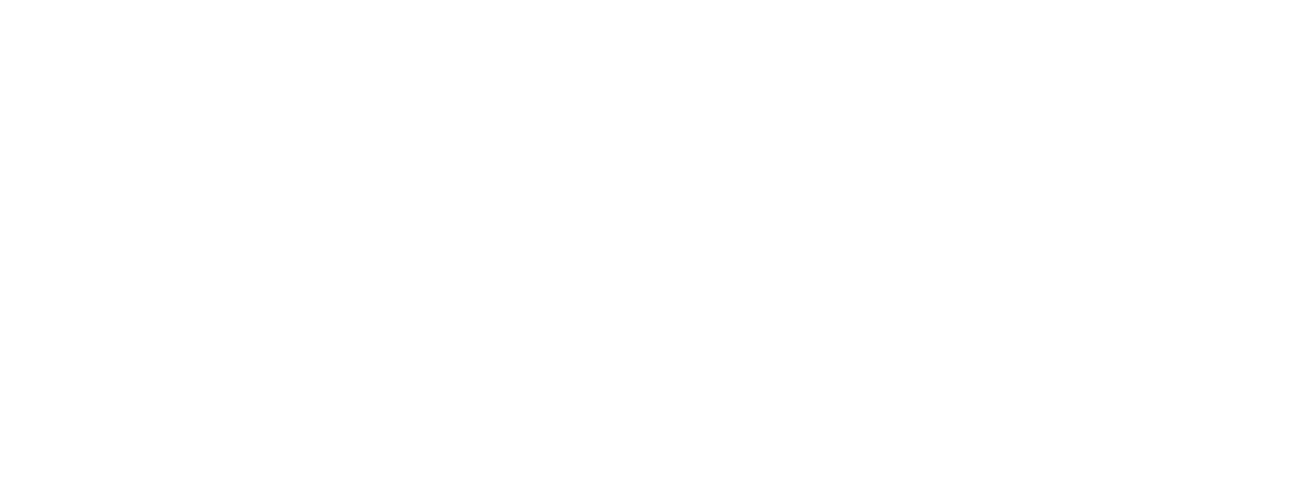

Day = 3
mae: 6.3870337352855975
mse: 84.9905952461653
rmse: 9.21903439879499
r2: -242.77332451190426
mape: 0.4198171028034669
mnbe: -21.240653289726144
r_coeff: [0.16333313]


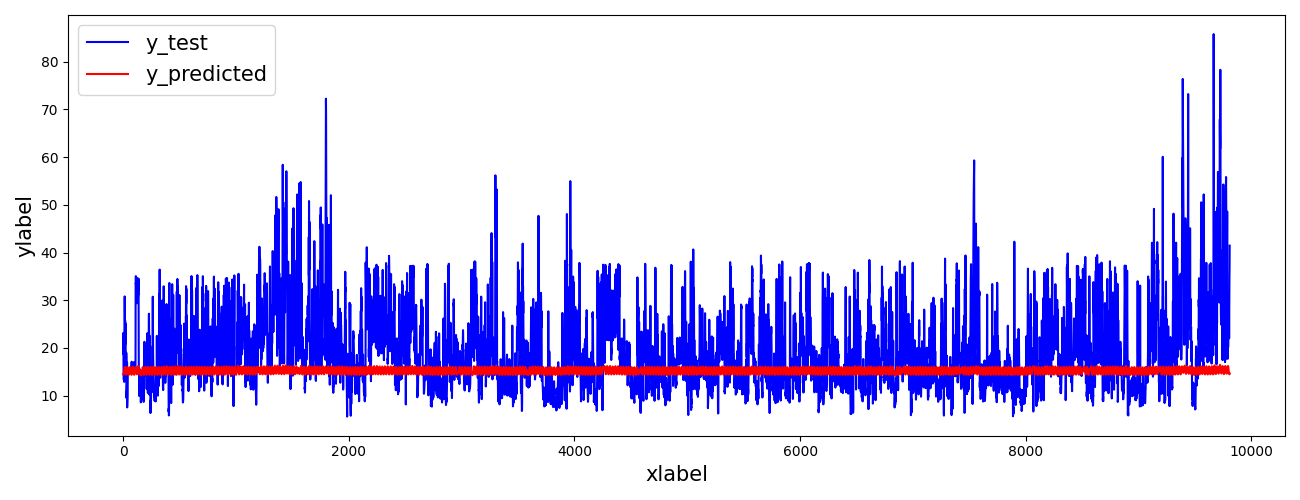

In [14]:
lstms2s_shifted_1 = define_lstms2s_model(n_past, n_future, X_train_shifted_1.shape[-1], y_train_shifted_1.shape[-1], "lstms2s_shifted_1")

history = lstms2s_shifted_1.fit(X_train_shifted_1, y_train_shifted_1,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_1 = lstms2s_shifted_1.predict(X_test_shifted_1)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_1[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_1[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 2

Model: "lstms2s_shifted_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 168, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 168, 128)  │     71,168 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 64),      │     49,408 │ lstm_8[0][0]      │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 4, 32)     │          0 │ dense_4[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 4, 64)     │     24,832 │ repeat_vector_2[… │
│                     │                   │            │ lstm_9[0][1],     │
│                     │                   │            │ lstm_9[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 4, 128)    │     98,816 │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 4, 1)      │        129 │ lstm_11[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 246,433 (962.63 KB)

 Trainable params: 246,433 (962.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - loss: 0.0053 - val_loss: 0.0014
Epoch 2/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: nan - val_loss: nan
Epoch 3/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: nan - val_loss: nan
Epoch 4/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: nan - val_loss: nan
Epoch 5/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: nan - val_loss: nan
Epoch 6/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: nan - val_loss: nan
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


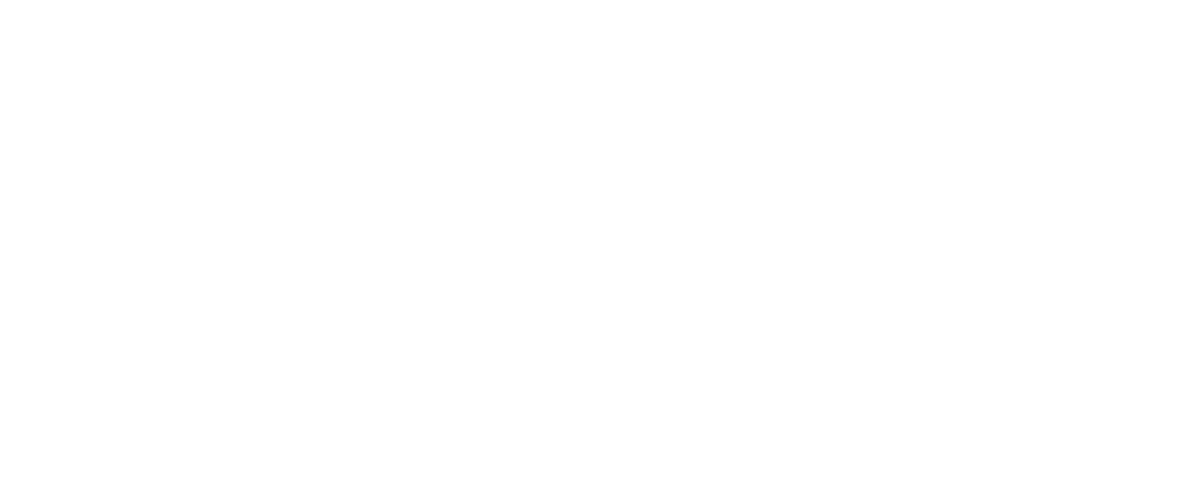

307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step
Day = 0
mae: 6.815542794082954
mse: 96.37999111974169
rmse: 9.817331160745352
r2: -736.331928194517
mape: 0.48531397976850665
mnbe: -27.26054107602507
r_coeff: [0.14014569]


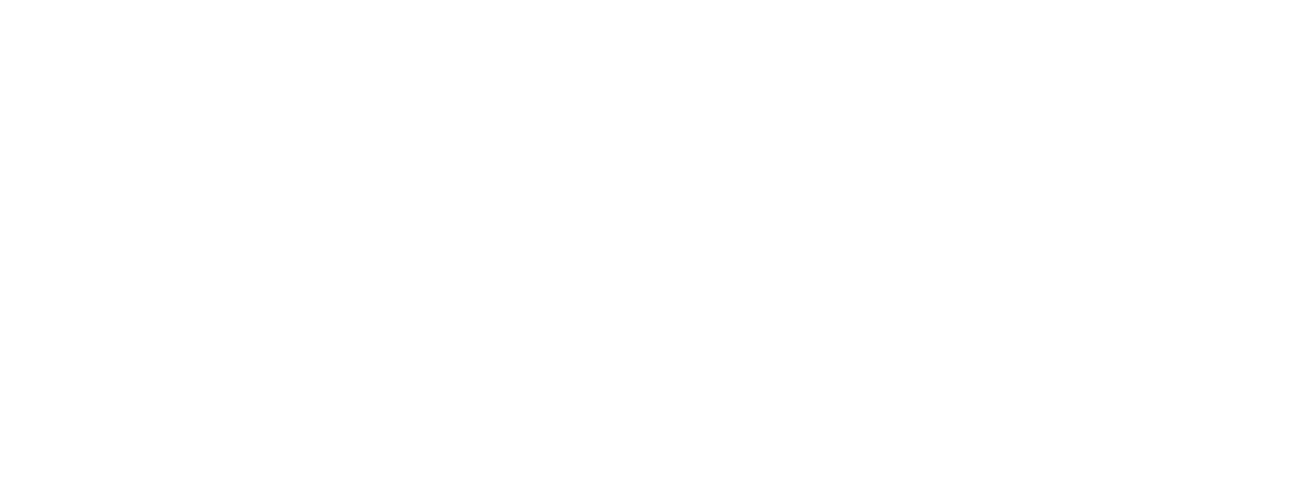

Day = 1
mae: 6.491229759358084
mse: 87.89123166835633
rmse: 9.375032355589838
r2: -717.5790405786274
mape: 0.43492940104451083
mnbe: -22.685127075013074
r_coeff: [0.14367646]


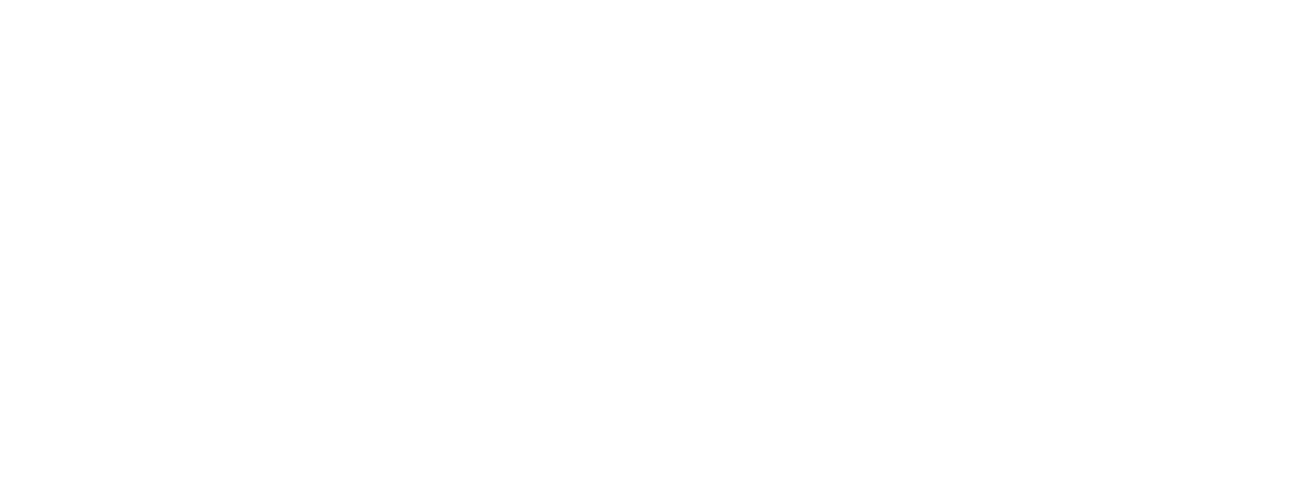

Day = 2
mae: 6.546762258160581
mse: 89.4348743195338
rmse: 9.457001338666174
r2: -1029.8833024221801
mape: 0.4434819257626737
mnbe: -23.504640642470648
r_coeff: [0.13516969]


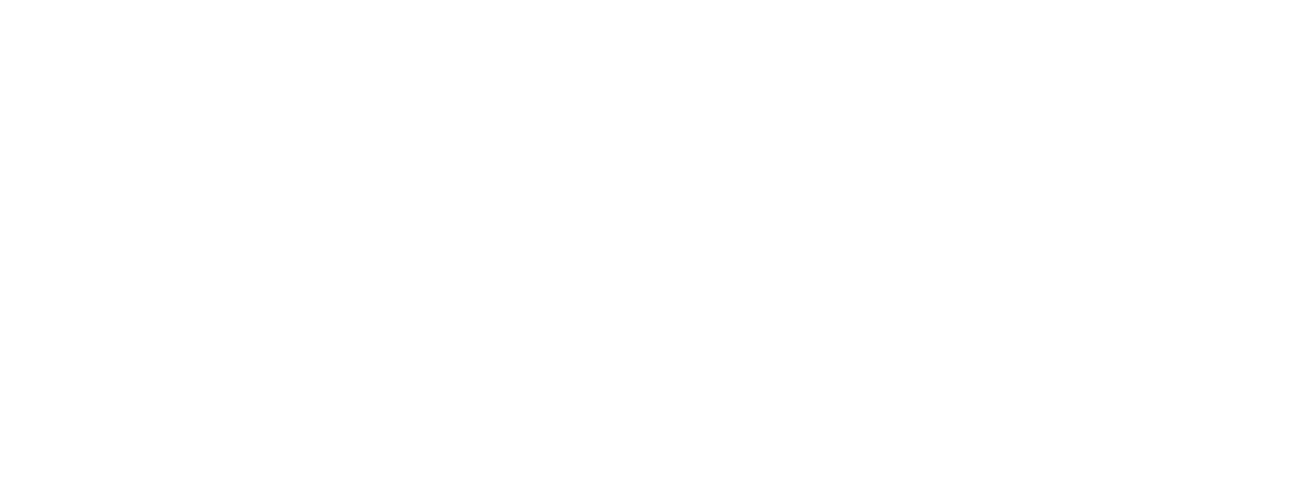

Day = 3
mae: 6.660607048845147
mse: 92.45450959543768
rmse: 9.61532680648129
r2: -1712.0644975629286
mape: 0.460908119999297
mnbe: -25.099413030064362
r_coeff: [0.12833038]


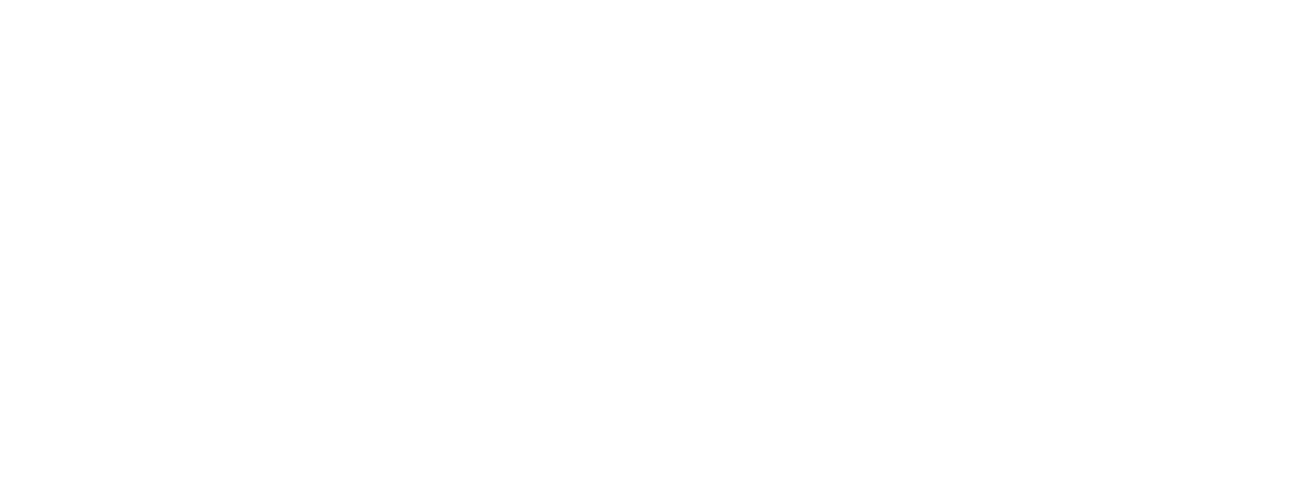

In [15]:
lstms2s_shifted_2 = define_lstms2s_model(n_past, n_future, X_train_shifted_2.shape[-1], y_train_shifted_2.shape[-1], "lstms2s_shifted_2")

history = lstms2s_shifted_2.fit(X_train_shifted_2, y_train_shifted_2,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_2 = lstms2s_shifted_2.predict(X_test_shifted_2)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_2[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_2[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 3

Model: "lstms2s_shifted_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 168, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 168, 128)  │     71,168 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ [(None, 64),      │     49,408 │ lstm_12[0][0]     │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 4, 32)     │          0 │ dense_6[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 4, 64)     │     24,832 │ repeat_vector_3[… │
│                     │                   │            │ lstm_13[0][1],    │
│                     │                   │            │ lstm_13[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 4, 128)    │     98,816 │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 4, 1)      │        129 │ lstm_15[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 246,433 (962.63 KB)

 Trainable params: 246,433 (962.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 38s 111ms/step - loss: 0.0054 - val_loss: 0.0014
Epoch 2/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 1111156480.0000 - val_loss: 0.0048
Epoch 3/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 4/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 5/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 6/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


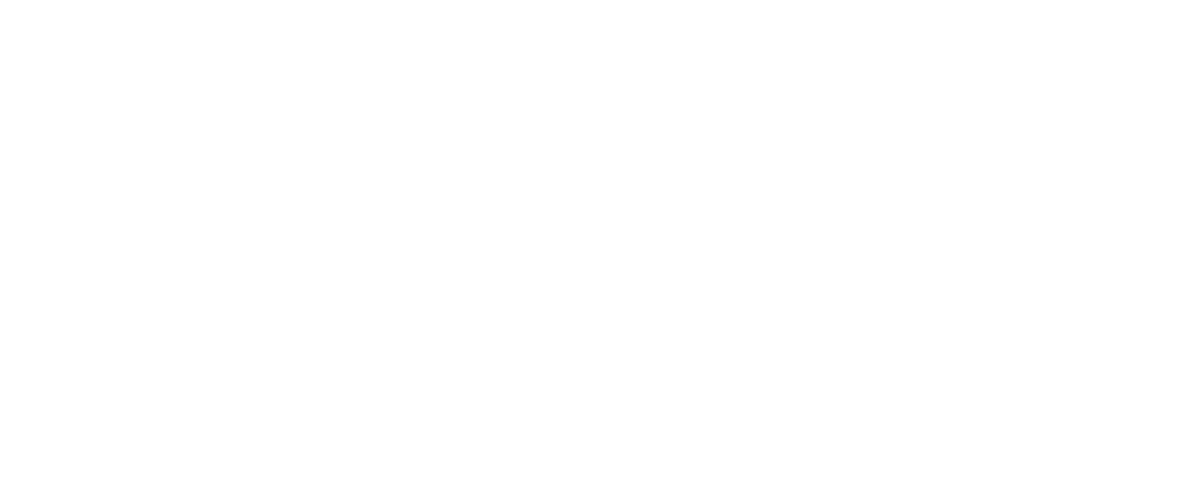

307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
Day = 0
mae: 6.2132586268580265
mse: 78.76077401580999
rmse: 8.874726700908033
r2: -439.11582342997673
mape: 0.38596062292905636
mnbe: -16.676179999322187
r_coeff: [0.17590702]


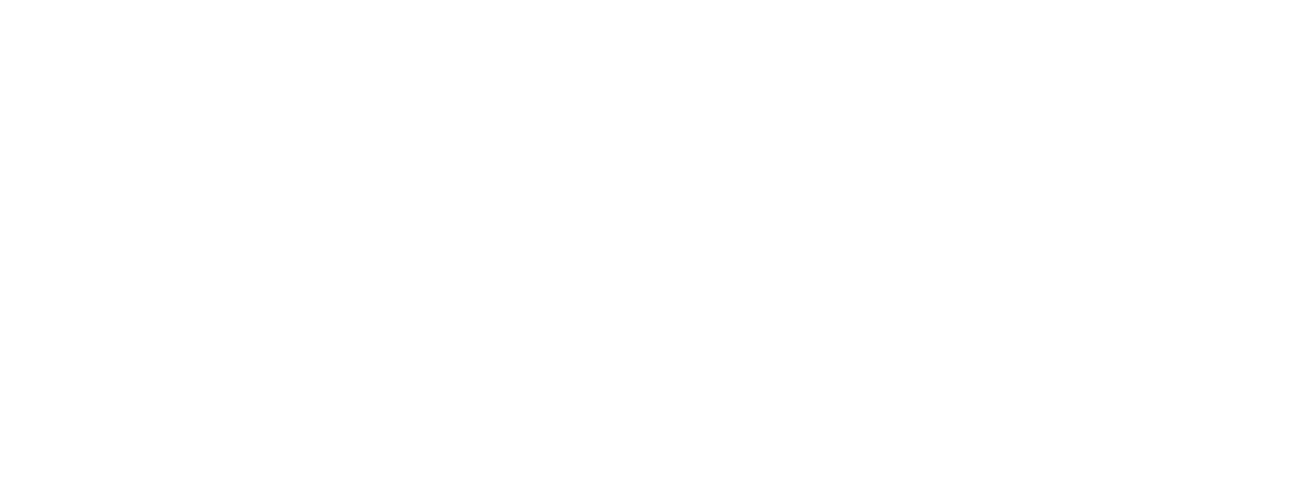

Day = 1
mae: 6.301876878823508
mse: 81.94751074047875
rmse: 9.052486439673839
r2: -540.6678862923787
mape: 0.4026460205102567
mnbe: -18.965352230826944
r_coeff: [0.16290322]


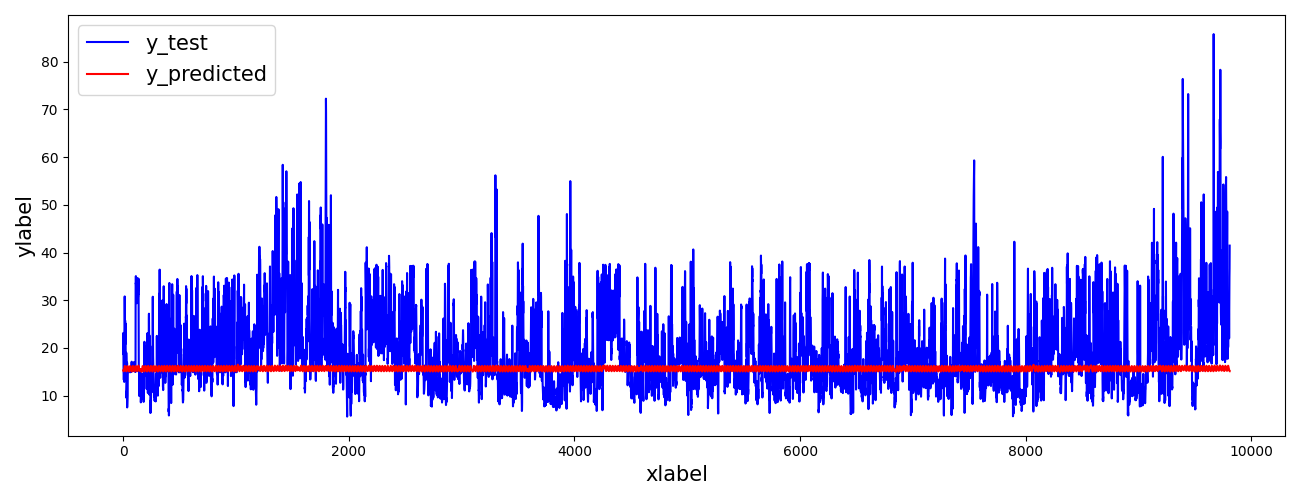

Day = 2
mae: 6.684352393520245
mse: 92.95741508599475
rmse: 9.641442583244208
r2: -1138.7028247303044
mape: 0.4645690623072622
mnbe: -25.480679783916276
r_coeff: [0.15496871]


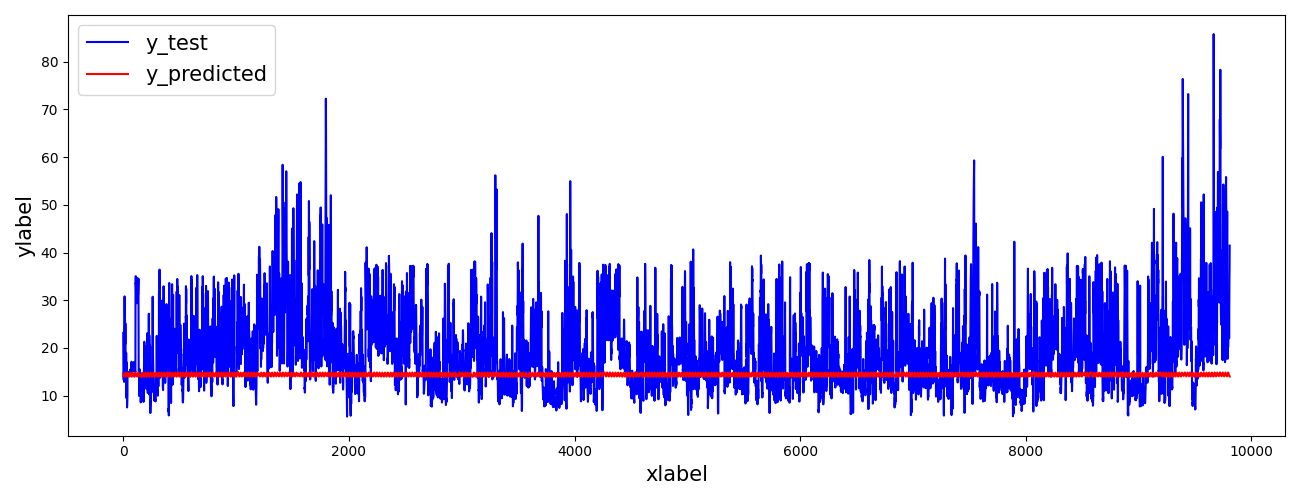

Day = 3
mae: 7.19911983603929
mse: 105.66549657655281
rmse: 10.279372382424562
r2: -2769.602394324775
mape: 0.5436941176513038
mnbe: -31.388955799482872
r_coeff: [0.14385074]


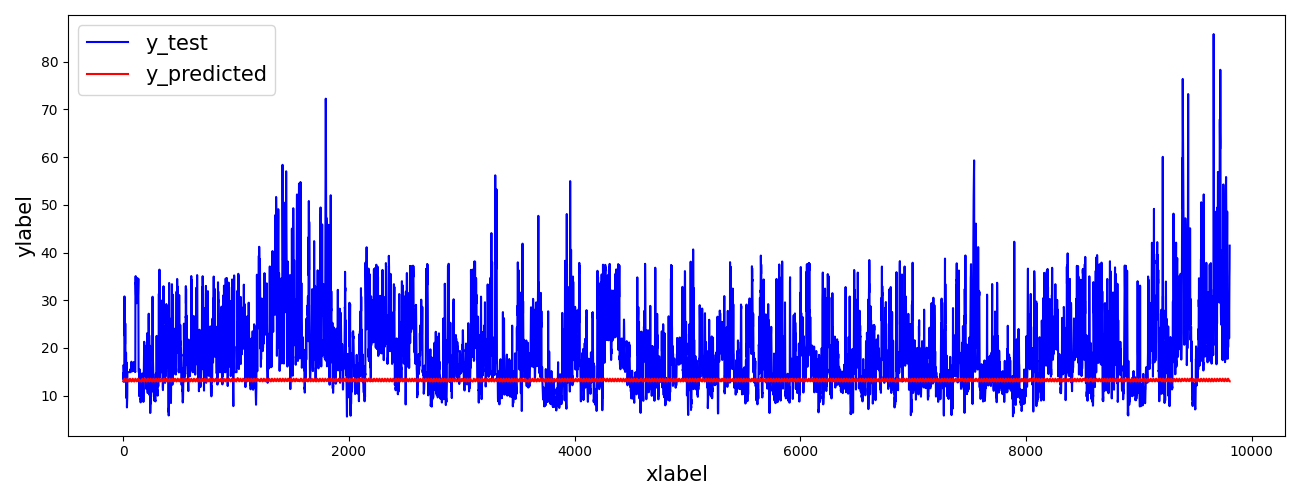

In [16]:
lstms2s_shifted_3 = define_lstms2s_model(n_past, n_future, X_train_shifted_3.shape[-1], y_train_shifted_3.shape[-1], "lstms2s_shifted_3")

history = lstms2s_shifted_3.fit(X_train_shifted_3, y_train_shifted_3,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_3 = lstms2s_shifted_3.predict(X_test_shifted_3)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_3[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_3[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 4

Model: "lstms2s_shifted_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 168, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 168, 128)  │     71,168 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ [(None, 64),      │     49,408 │ lstm_16[0][0]     │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      2,080 │ lstm_17[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 4, 32)     │          0 │ dense_8[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 4, 64)     │     24,832 │ repeat_vector_4[… │
│                     │                   │            │ lstm_17[0][1],    │
│                     │                   │            │ lstm_17[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 4, 128)    │     98,816 │ lstm_18[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 4, 1)      │        129 │ lstm_19[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 246,433 (962.63 KB)

 Trainable params: 246,433 (962.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 2/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 2089.5664 - val_loss: 0.0023
Epoch 3/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0047 - val_loss: 45485196836864.0000
Epoch 4/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: nan - val_loss: nan
Epoch 5/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: nan - val_loss: nan
Epoch 6/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: nan - val_loss: nan
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/src/plot.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


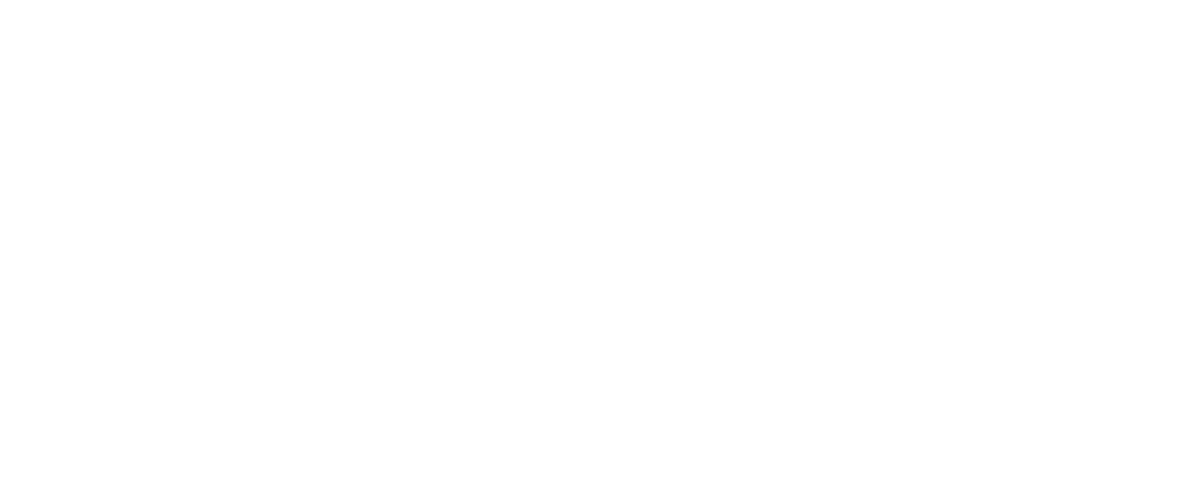

307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
Day = 0
mae: 6.991411219192007
mse: 100.67452832739771
rmse: 10.033669733821107
r2: -404.0110036642992
mape: 0.5132930854579532
mnbe: -29.563658881890408
r_coeff: [0.1836782]


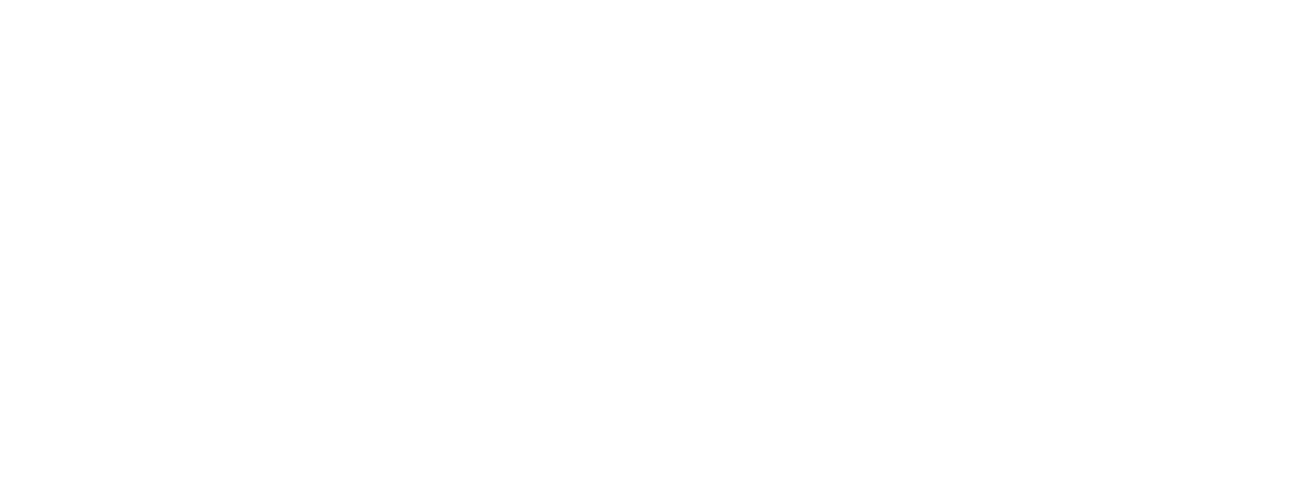

Day = 1
mae: 6.713813991185291
mse: 93.8756866241112
rmse: 9.688946620975429
r2: -484.18893927727925
mape: 0.47060329947583757
mnbe: -26.17225242851952
r_coeff: [0.17154885]


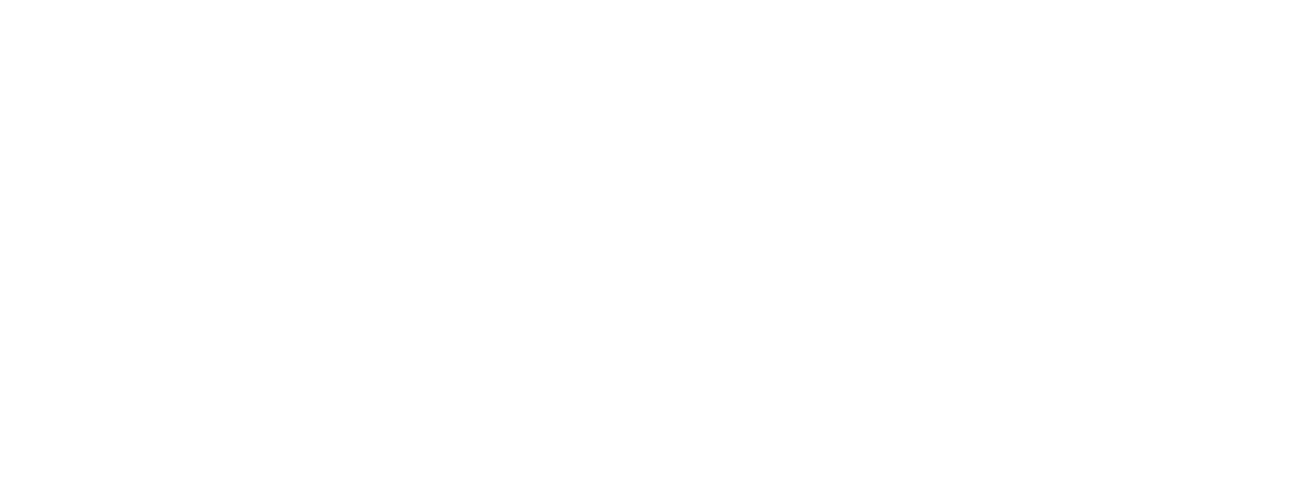

Day = 2
mae: 6.712136561033541
mse: 93.87949316922094
rmse: 9.689143056494776
r2: -724.5581420231686
mape: 0.4699278920256334
mnbe: -26.03172334964062
r_coeff: [0.15378175]


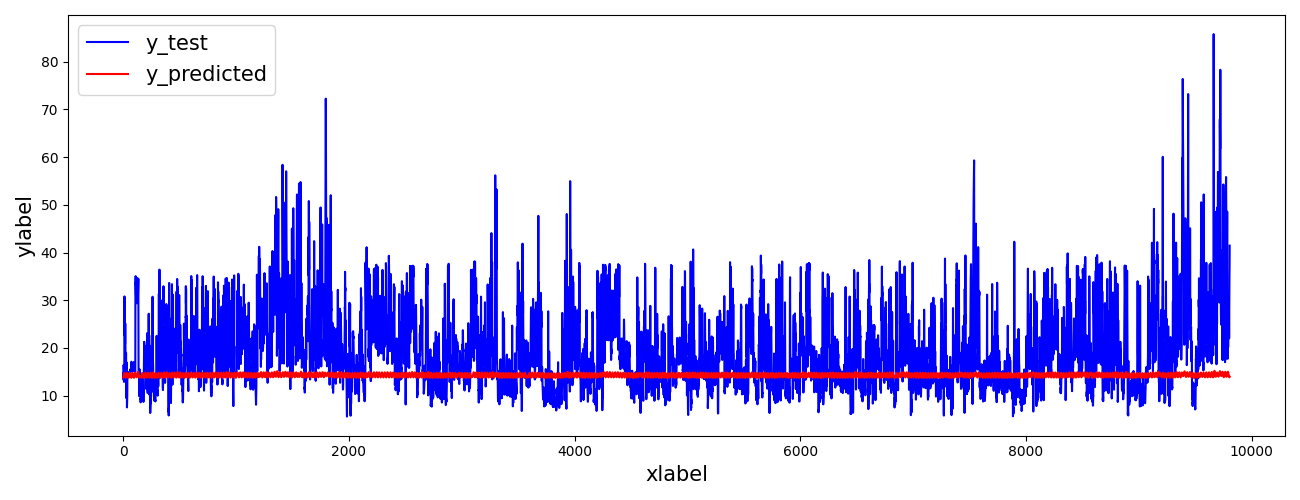

Day = 3
mae: 6.733255024274012
mse: 94.4122499671244
rmse: 9.716596624699639
r2: -1121.687435736944
mape: 0.4726454832134589
mnbe: -26.181320132364363
r_coeff: [0.13262903]


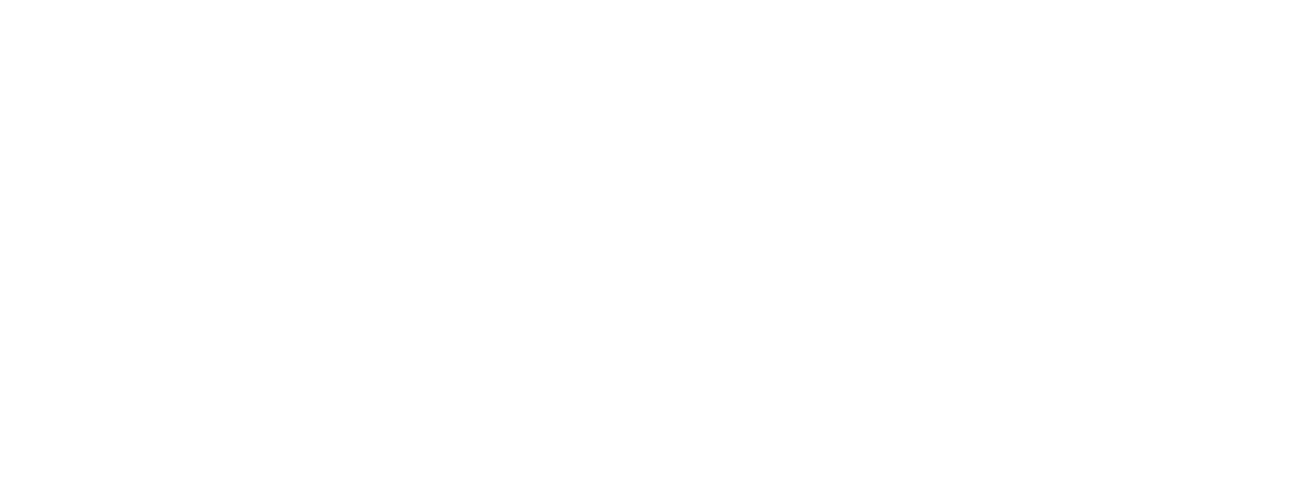

In [17]:
lstms2s_shifted4 = define_lstms2s_model(n_past, n_future,  X_train_shifted_4.shape[-1], y_train_shifted_4.shape[-1], "lstms2s_shifted_4")

history = lstms2s_shifted4.fit(X_train_shifted_4, y_train_shifted_4,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_4 = lstms2s_shifted4.predict(X_test_shifted_4)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_4[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_4[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

### GRU-Seq2Seq

In [18]:
def define_grus2s_model(n_past, n_future, n_features, n_label, name="model"):
    # encoder layers
    encoder_inputs = Input(shape=(n_past, n_features))
    encoder_gru_1 = GRU(128, return_sequences=True, activation="relu")(encoder_inputs)
    encoder_gru_2, state_h = GRU(64, return_state=True, activation="relu")(encoder_gru_1)
    encoder_dropout = Dropout(0.2)(encoder_gru_2)
    encoder_dense = Dense(latent_dim)(encoder_dropout)
    # Repeat layer
    decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
    # Decoder layers
    decoder_gru_1 = GRU(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=state_h)
    decoder_gru_2 = GRU(128, return_sequences=True, activation="relu")(decoder_gru_1)
    decoder_dropout = Dropout(0.2)(decoder_gru_2)
    decoder_outputs = TimeDistributed(Dense(n_label))(decoder_dropout)
    # Compile the model
    model = Model(encoder_inputs, decoder_outputs)
    model.name = name
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
    display(model.summary())
    return model

#### No shift

Model: "grus2s_no_shift"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 168, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 168, 128)  │     53,760 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, 64),      │     37,248 │ gru[0][0]         │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_5     │ (None, 4, 32)     │          0 │ dense_10[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 4, 64)     │     18,816 │ repeat_vector_5[… │
│                     │                   │            │ gru_1[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 4, 128)    │     74,496 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 4, 128)    │          0 │ gru_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 4, 1)      │        129 │ dropout_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 186,529 (728.63 KB)

 Trainable params: 186,529 (728.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 45s 112ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 2/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 3/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 4/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 5/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 6/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


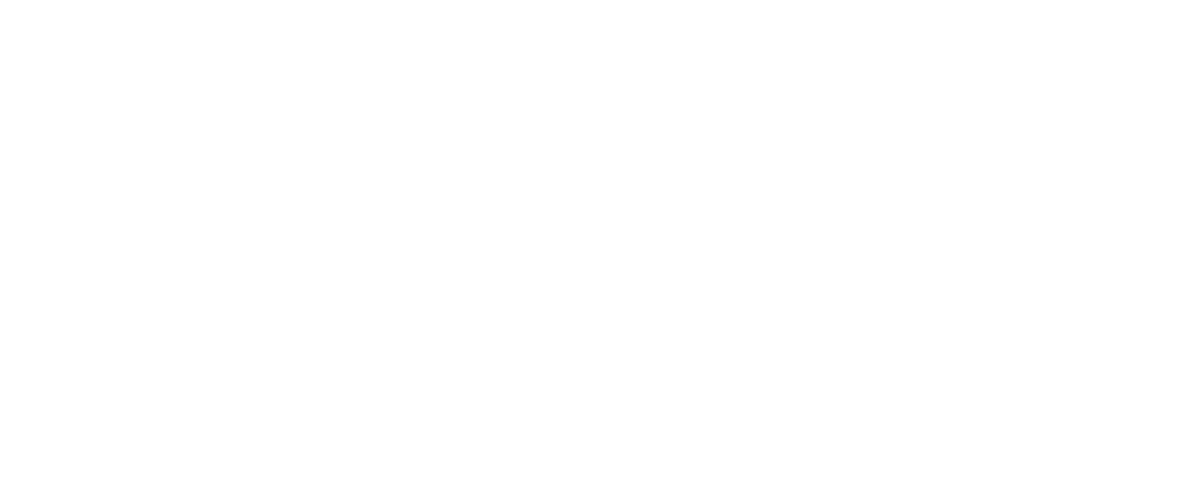

307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
Day = 0
mae: 5.8047402309607525
mse: 60.39212962210091
rmse: 7.771237328900779
r2: -6.34997910203208
mape: 0.30829334935361374
mnbe: -2.6444423038230256
r_coeff: [0.3676126]


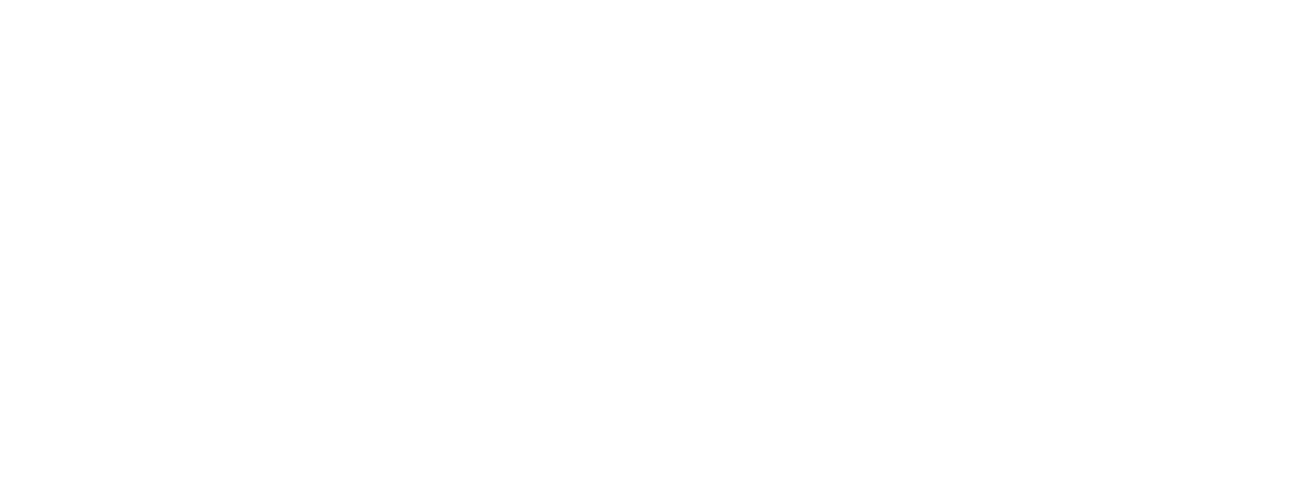

Day = 1
mae: 5.785946975784889
mse: 63.130846194824684
rmse: 7.945492193365033
r2: -13.115514597270272
mape: 0.32074603029366244
mnbe: -7.012034215763277
r_coeff: [0.3589822]


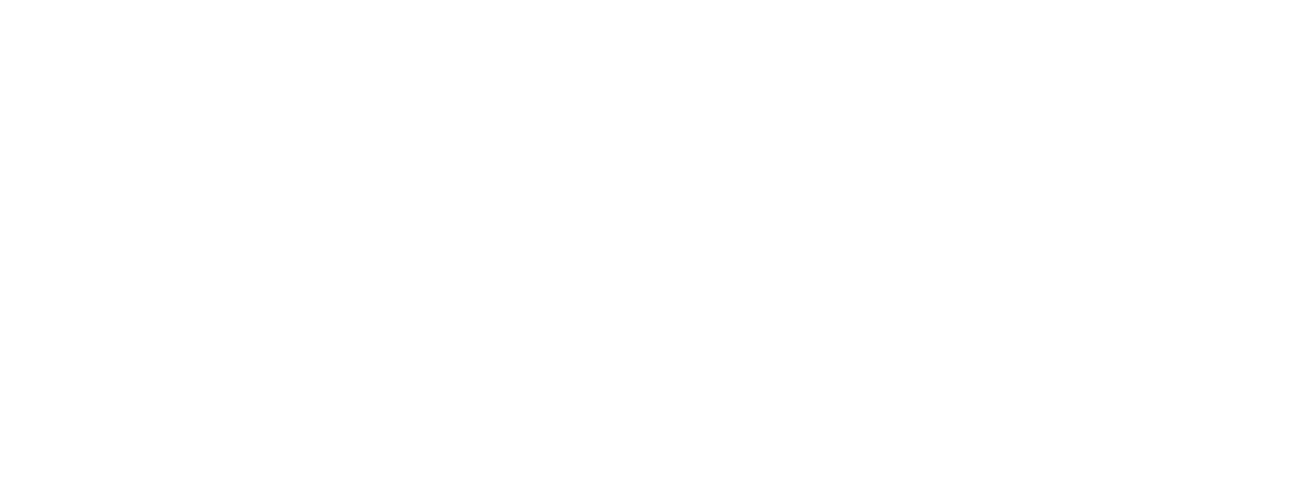

Day = 2
mae: 5.856639002939767
mse: 66.27004211001892
rmse: 8.14064138198084
r2: -31.77176040501834
mape: 0.3316804503533167
mnbe: -9.163090456878512
r_coeff: [0.35274088]


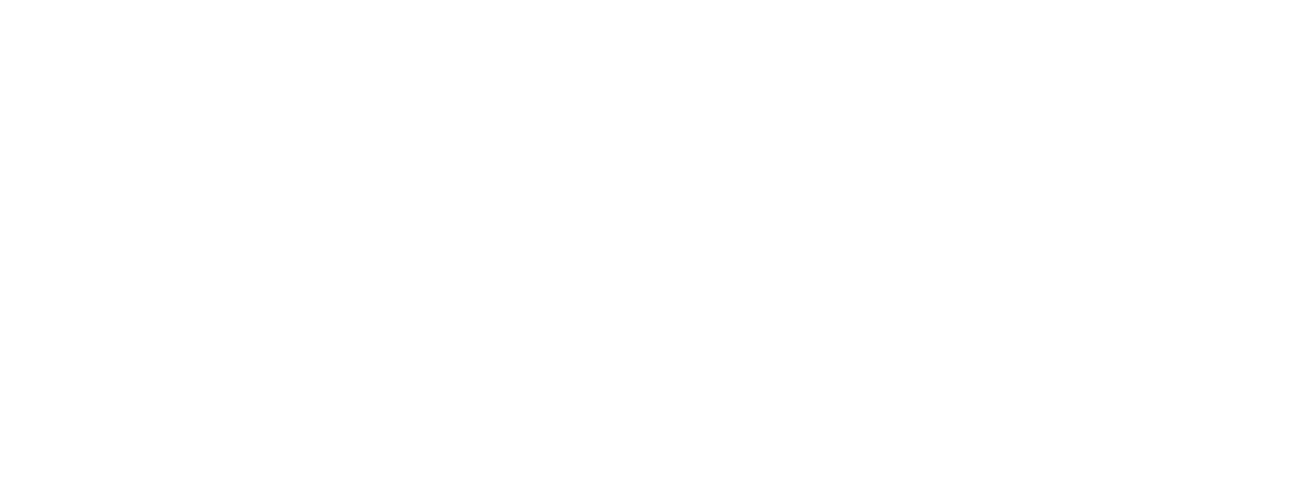

Day = 3
mae: 5.934079254646479
mse: 68.83100735504465
rmse: 8.296445465079888
r2: -71.2123635930853
mape: 0.34098657660700327
mnbe: -10.416798016166046
r_coeff: [0.34688023]


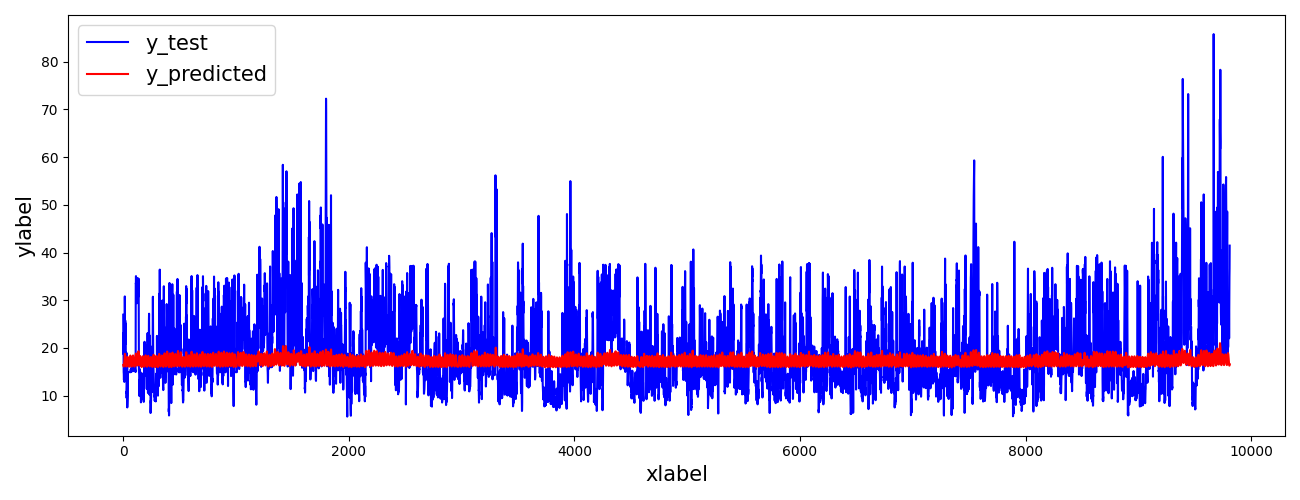

In [19]:
grus2s = define_grus2s_model(n_past, n_future, X_train.shape[-1], y_train.shape[-1], "grus2s_no_shift")

history = grus2s.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = grus2s.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 1

Model: "grus2s_shifted_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 168, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 168, 128)  │     53,760 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ [(None, 64),      │     37,248 │ gru_4[0][0]       │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 4, 32)     │          0 │ dense_12[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 4, 64)     │     18,816 │ repeat_vector_6[… │
│                     │                   │            │ gru_5[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 4, 128)    │     74,496 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 4, 128)    │          0 │ gru_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 4, 1)      │        129 │ dropout_3[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 186,529 (728.63 KB)

 Trainable params: 186,529 (728.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 2/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 3/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 4/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 5/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 6/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 7/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


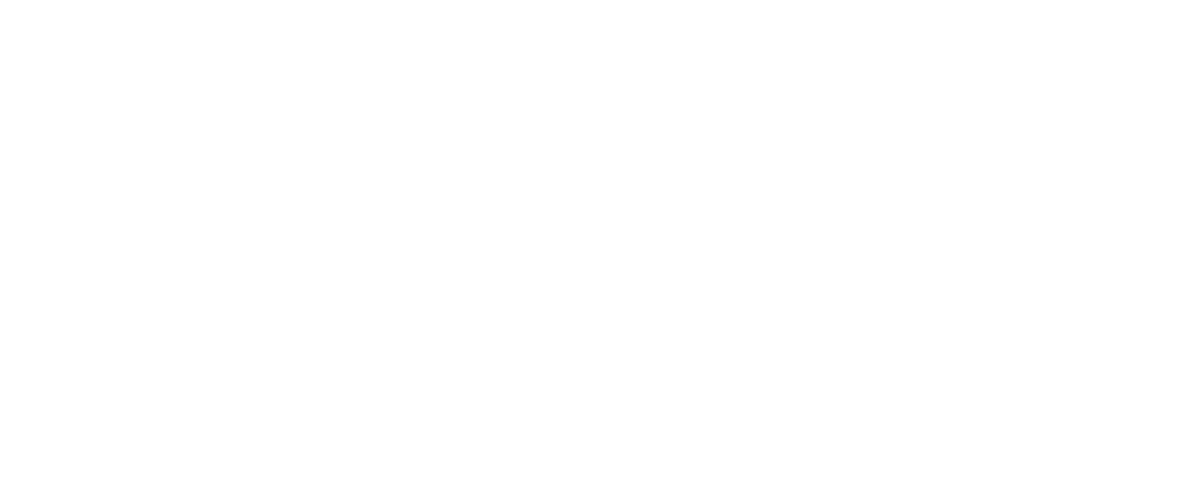

307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
Day = 0
mae: 6.065825761628475
mse: 66.36928321659715
rmse: 8.14673451246554
r2: -6.253821473357581
mape: 0.32642567428703717
mnbe: -3.458111714292612
r_coeff: [0.25210446]


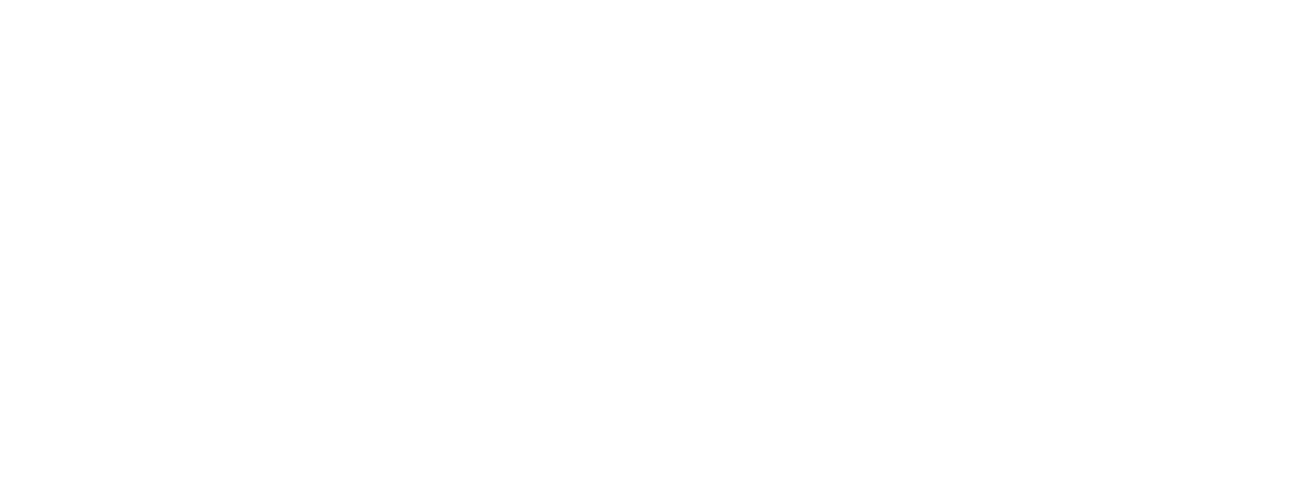

Day = 1
mae: 6.004298508182135
mse: 70.8458547790365
rmse: 8.416997967151739
r2: -16.162656638412898
mape: 0.3549171645070294
mnbe: -12.317897539008966
r_coeff: [0.24827489]


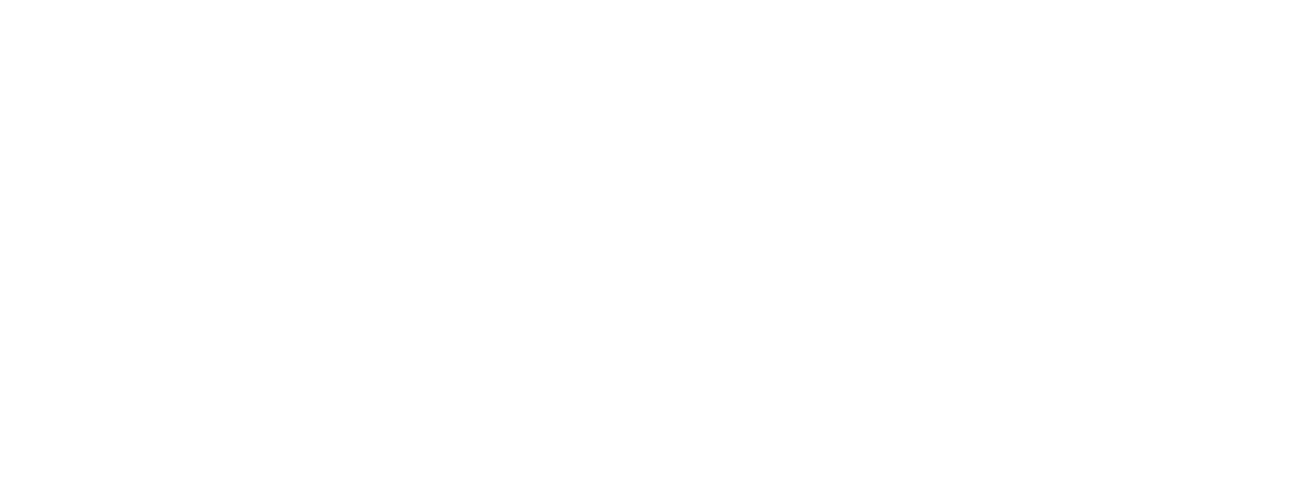

Day = 2
mae: 6.11815788816691
mse: 76.28857164989664
rmse: 8.734332925295247
r2: -51.957385099143636
mape: 0.3790391924309224
mnbe: -16.700857424350307
r_coeff: [0.2501153]


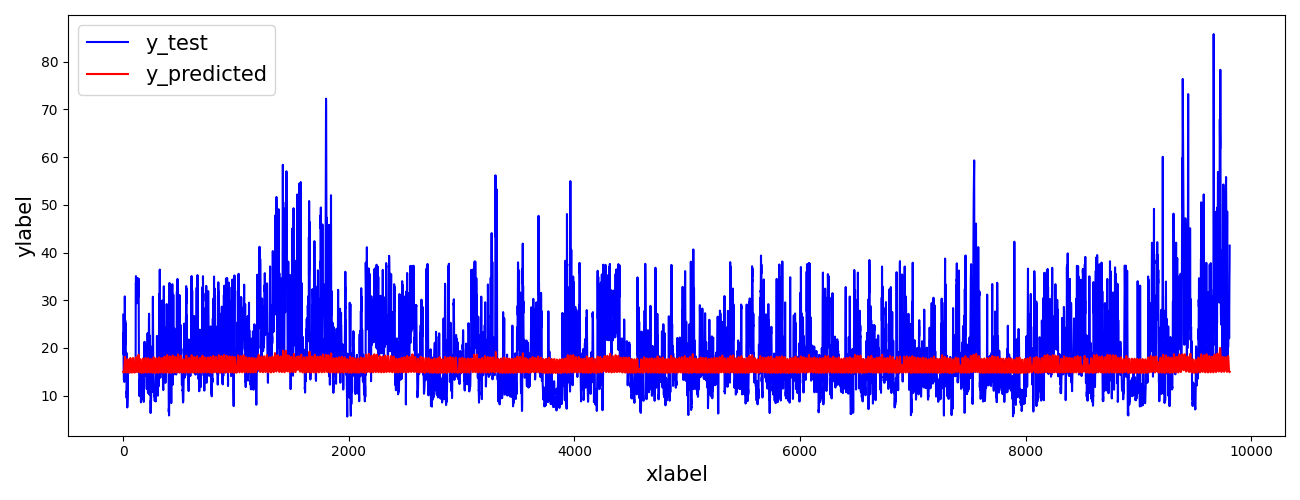

Day = 3
mae: 6.232937469824342
mse: 80.22522695759206
rmse: 8.956853630466005
r2: -137.4945419160199
mape: 0.3967473390659221
mnbe: -18.954300626432474
r_coeff: [0.25147625]


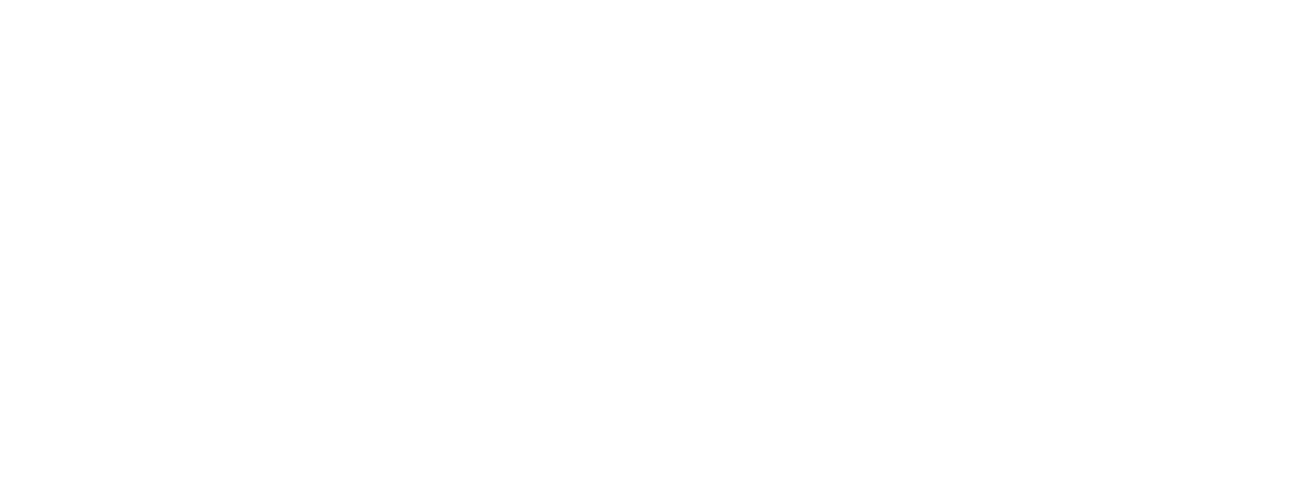

In [20]:
grus2s_shifted1 = define_grus2s_model(n_past, n_future, X_train_shifted_1.shape[-1], y_train_shifted_1.shape[-1], "grus2s_shifted_1")

history = grus2s_shifted1.fit(X_train_shifted_1, y_train_shifted_1,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_1 = grus2s_shifted1.predict(X_test_shifted_1)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_1[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_1[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 2

Model: "grus2s_shifted_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 168, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 168, 128)  │     53,760 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ [(None, 64),      │     37,248 │ gru_8[0][0]       │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_7     │ (None, 4, 32)     │          0 │ dense_14[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_10 (GRU)        │ (None, 4, 64)     │     18,816 │ repeat_vector_7[… │
│                     │                   │            │ gru_9[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_11 (GRU)        │ (None, 4, 128)    │     74,496 │ gru_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 4, 128)    │          0 │ gru_11[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 4, 1)      │        129 │ dropout_5[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 186,529 (728.63 KB)

 Trainable params: 186,529 (728.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 31s 82ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 2/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 3/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 4/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 5/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 6/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 7/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 8/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


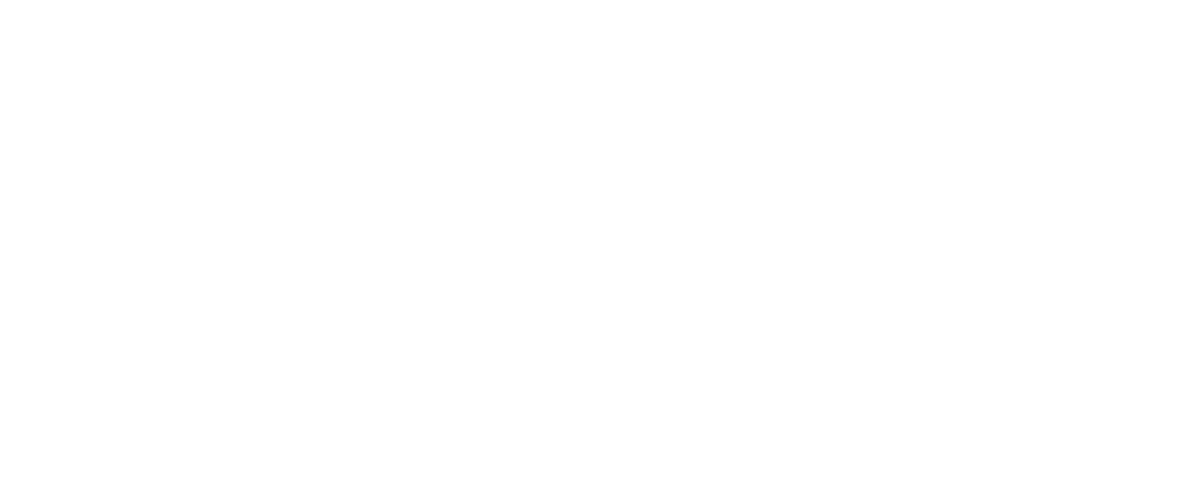

307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
Day = 0
mae: 6.044690999325401
mse: 63.493977339873375
rmse: 7.9683108209879325
r2: -14.404128553467293
mape: 0.31036171738456125
mnbe: 0.6487515001235387
r_coeff: [0.29944407]


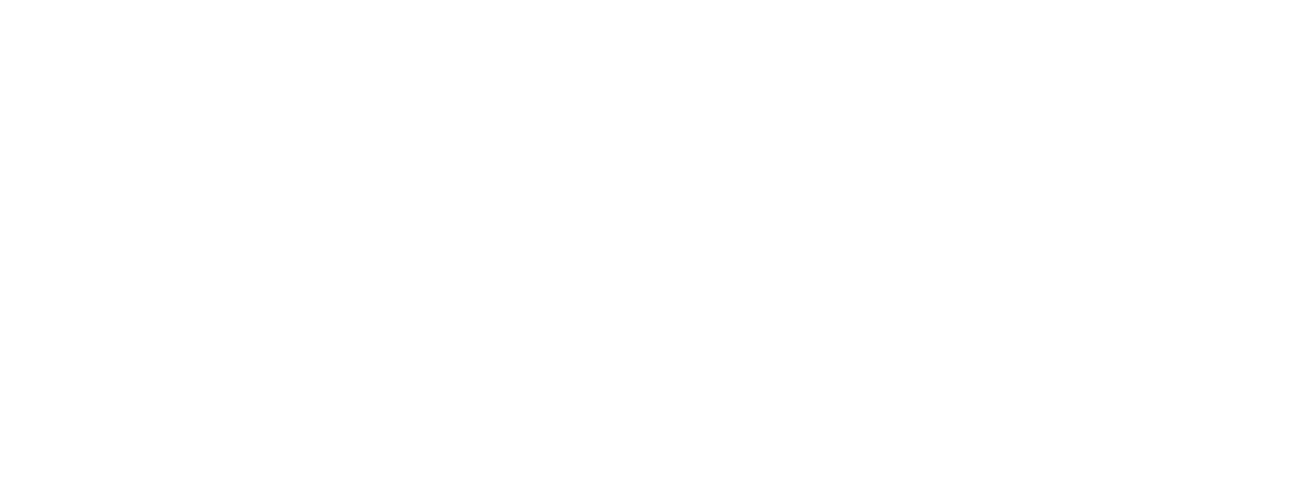

Day = 1
mae: 5.946879080016832
mse: 65.29905234717732
rmse: 8.080782904346417
r2: -26.67227529433389
mape: 0.32242040618208023
mnbe: -4.772376254929791
r_coeff: [0.28896304]


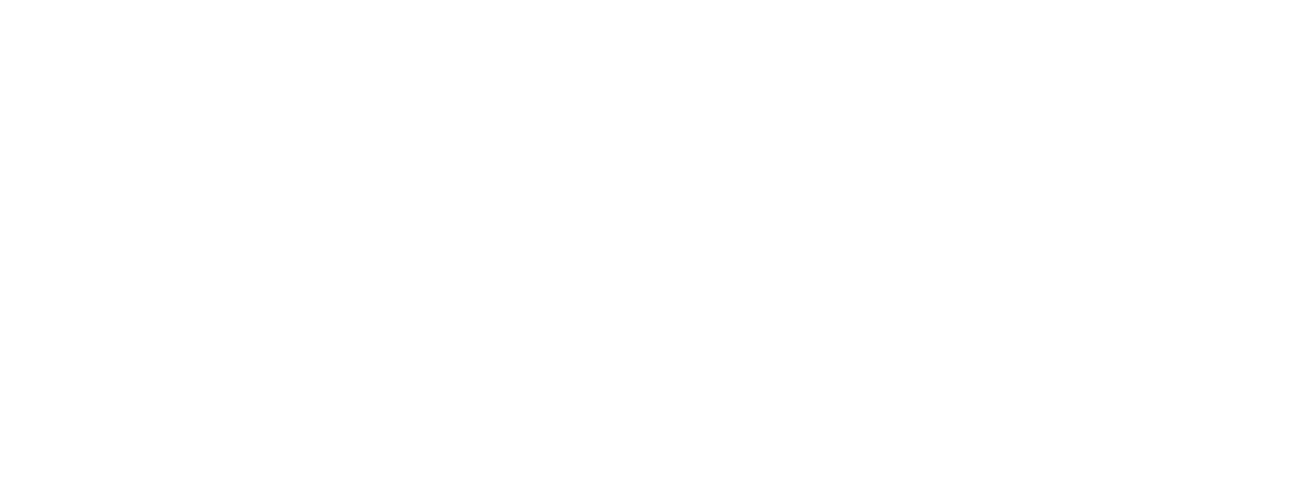

Day = 2
mae: 5.972249489846623
mse: 68.10841136314839
rmse: 8.252782037782676
r2: -62.466557448387185
mape: 0.3352524900058135
mnbe: -8.045114666878051
r_coeff: [0.28159474]


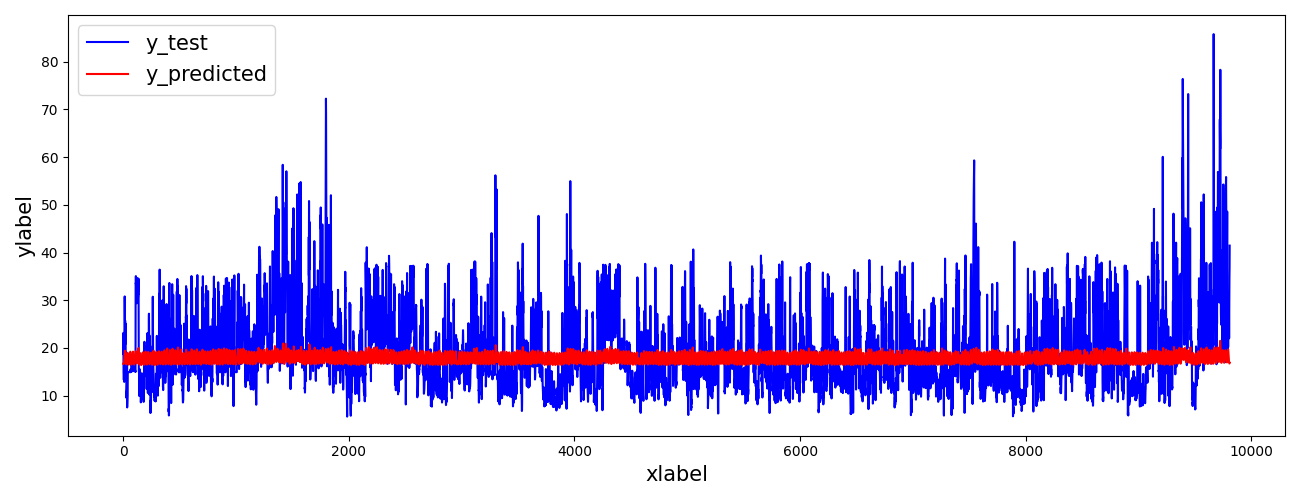

Day = 3
mae: 6.020642539469911
mse: 70.61429185035487
rmse: 8.403231036354699
r2: -140.8598487684162
mape: 0.3462559215383921
mnbe: -10.194234284542706
r_coeff: [0.27585965]


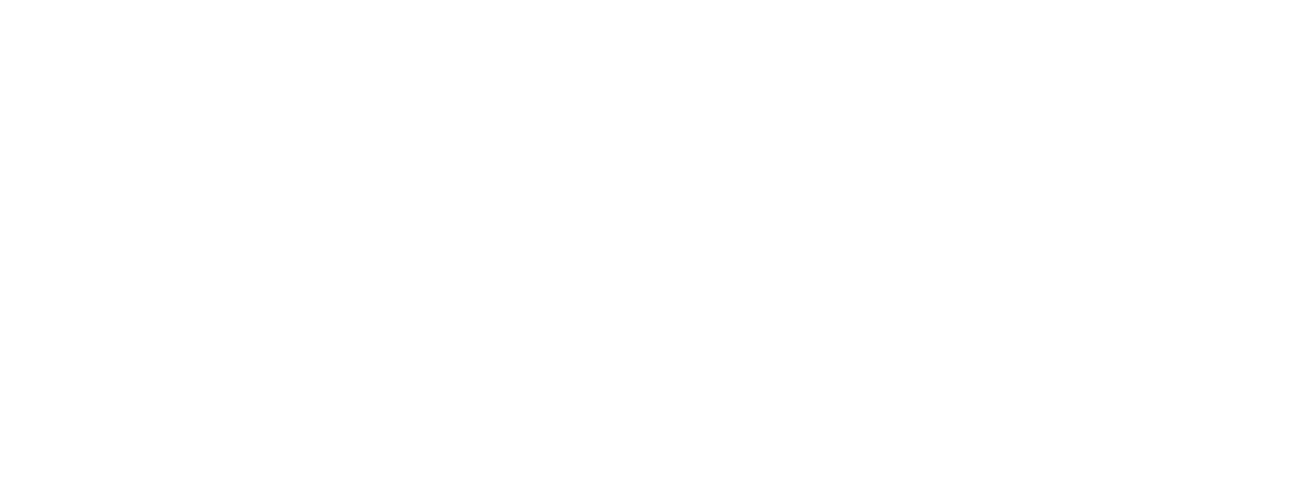

In [21]:
grus2s_shifted_2 = define_grus2s_model(n_past, n_future, X_train_shifted_2.shape[-1], y_train_shifted_2.shape[-1], "grus2s_shifted_2")

history = grus2s_shifted_2.fit(X_train_shifted_2, y_train_shifted_2,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_2 = grus2s_shifted_2.predict(X_test_shifted_2)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_2[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_2[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 3

Model: "grus2s_shifted_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 168, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_12 (GRU)        │ (None, 168, 128)  │     53,760 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ [(None, 64),      │     37,248 │ gru_12[0][0]      │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ gru_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_8     │ (None, 4, 32)     │          0 │ dense_16[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 4, 64)     │     18,816 │ repeat_vector_8[… │
│                     │                   │            │ gru_13[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 4, 128)    │     74,496 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 4, 128)    │          0 │ gru_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 4, 1)      │        129 │ dropout_7[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 186,529 (728.63 KB)

 Trainable params: 186,529 (728.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - loss: 0.0050 - val_loss: 0.0017
Epoch 2/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0048 - val_loss: 0.0014
Epoch 3/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 4/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 5/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 6/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 7/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


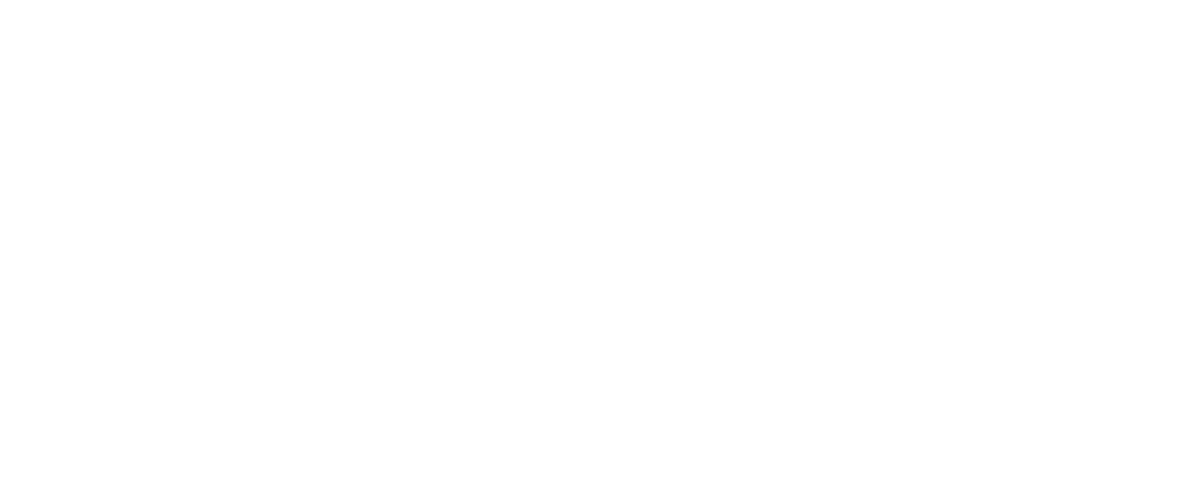

307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
Day = 0
mae: 6.218105979388094
mse: 78.82895989102654
rmse: 8.878567445879236
r2: -44.59755678115893
mape: 0.39282170499650637
mnbe: -18.098607844043197
r_coeff: [0.20798543]


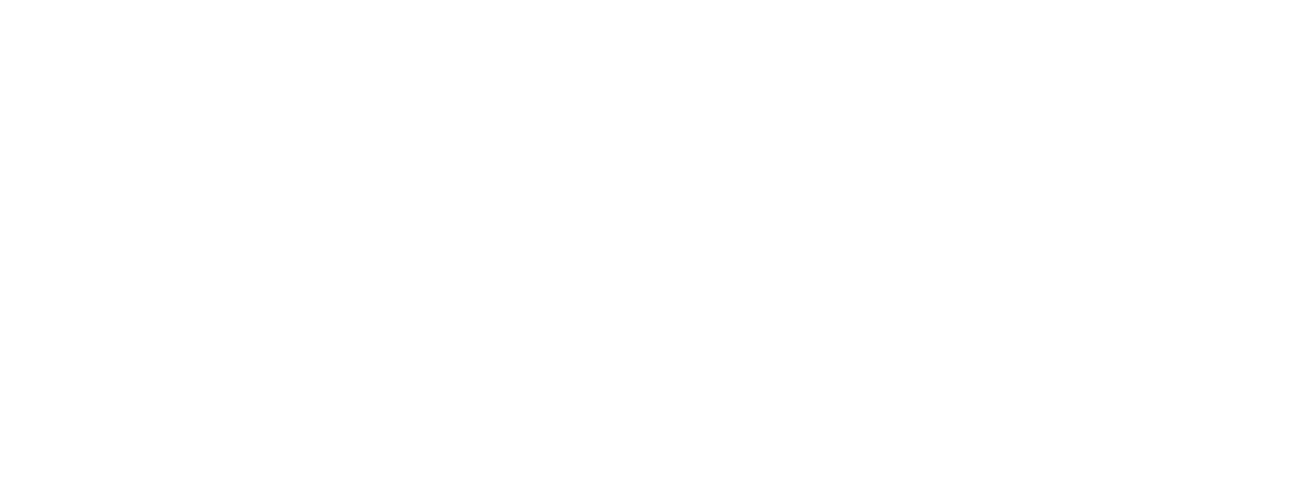

Day = 1
mae: 6.412396396768132
mse: 85.37368257594143
rmse: 9.239788015746976
r2: -187.94482668707323
mape: 0.42414930881595764
mnbe: -21.908276430341726
r_coeff: [0.21395473]


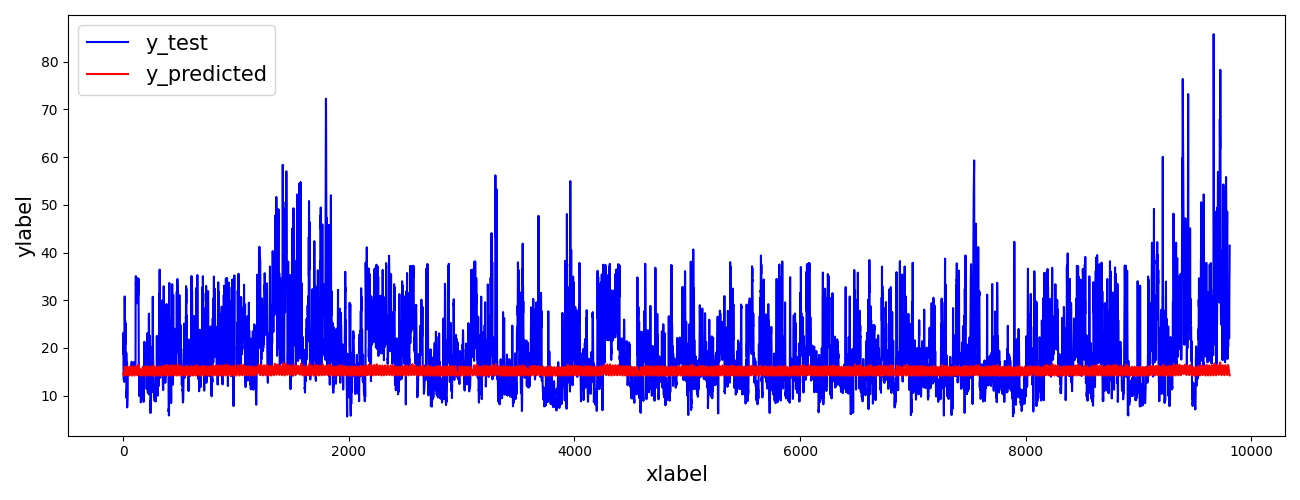

Day = 2
mae: 6.5546987505637695
mse: 89.43188441884301
rmse: 9.456843258658939
r2: -454.13661586372365
mape: 0.44557342247270126
mnbe: -23.977467711794713
r_coeff: [0.21883901]


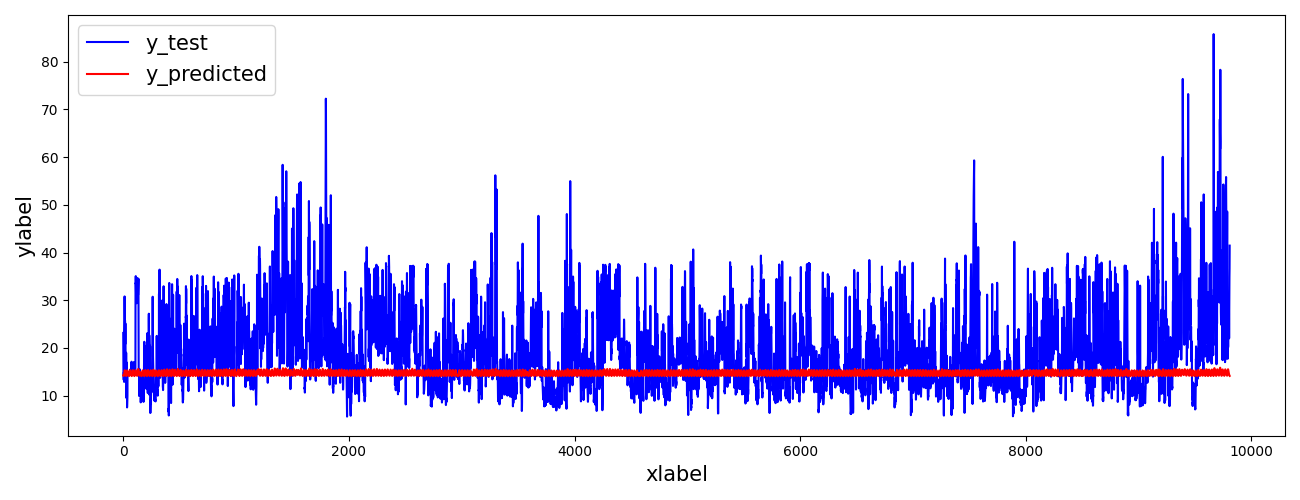

Day = 3
mae: 6.604430832666069
mse: 90.82316148719188
rmse: 9.530118650215845
r2: -828.9103509803889
mape: 0.4527974529040731
mnbe: -24.573910048223166
r_coeff: [0.22101964]


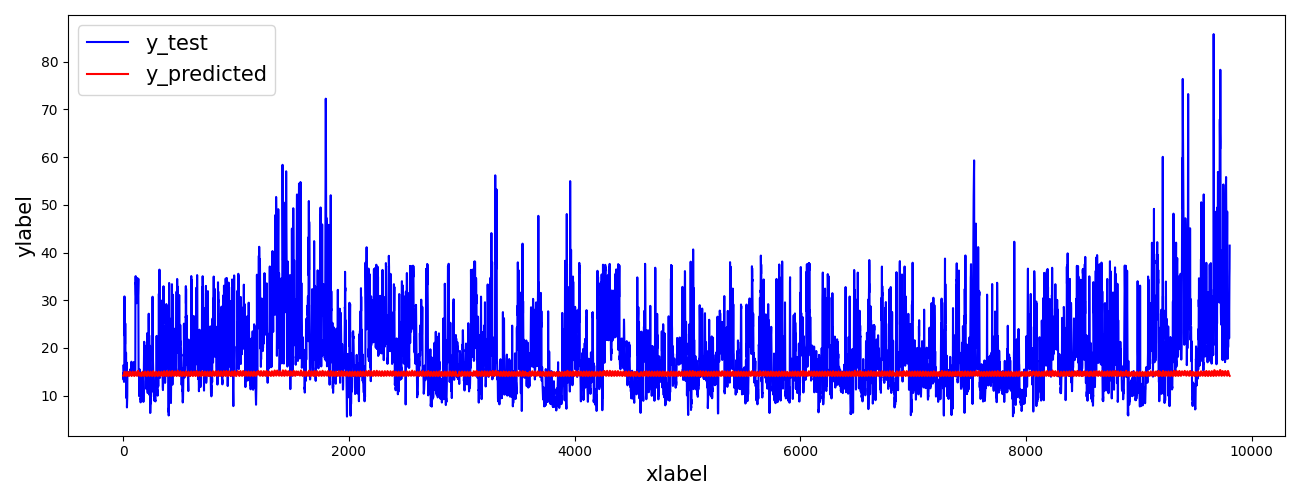

In [22]:
grus2s_shifted_3 = define_grus2s_model(n_past, n_future, X_train_shifted_3.shape[-1], y_train_shifted_3.shape[-1], "grus2s_shifted_3")

history = grus2s_shifted_3.fit(X_train_shifted_3, y_train_shifted_3,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_3 = grus2s_shifted_3.predict(X_test_shifted_3)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_3[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_3[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 4

Model: "grus2s_shifted_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 168, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_16 (GRU)        │ (None, 168, 128)  │     53,760 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_17 (GRU)        │ [(None, 64),      │     37,248 │ gru_16[0][0]      │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ gru_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │      2,080 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_9     │ (None, 4, 32)     │          0 │ dense_18[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_18 (GRU)        │ (None, 4, 64)     │     18,816 │ repeat_vector_9[… │
│                     │                   │            │ gru_17[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 4, 128)    │     74,496 │ gru_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 4, 128)    │          0 │ gru_19[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 4, 1)      │        129 │ dropout_9[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 186,529 (728.63 KB)

 Trainable params: 186,529 (728.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 37s 105ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 2/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 3/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 4/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 5/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 6/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 7/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 8/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 9/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


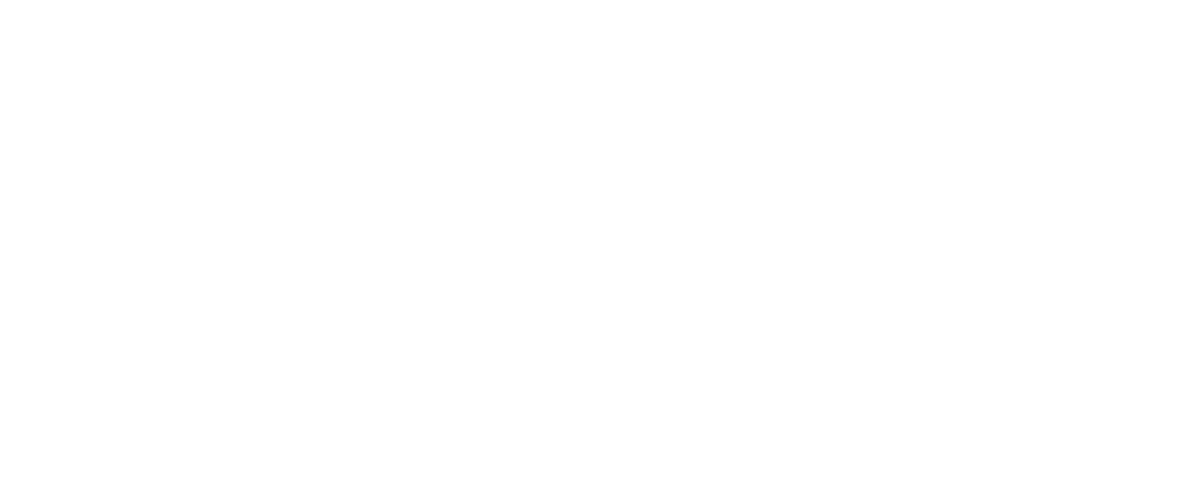

307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
Day = 0
mae: 6.088390089740373
mse: 64.25357554851279
rmse: 8.015832804426049
r2: -51.22969835238419
mape: 0.31252209526406316
mnbe: 0.768329735785803
r_coeff: [0.3511598]


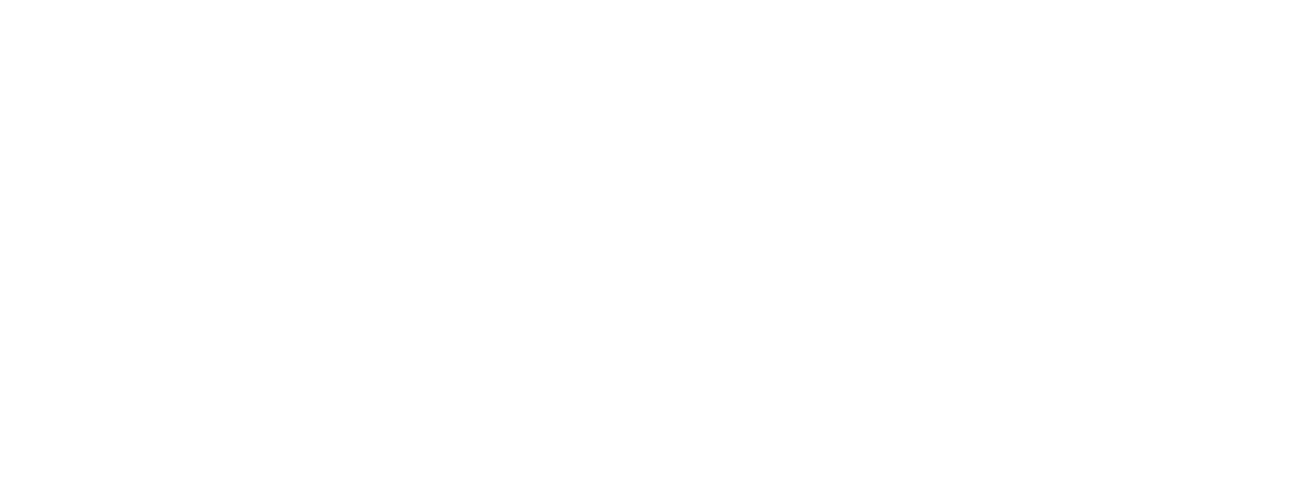

Day = 1
mae: 5.952978259358824
mse: 66.85963190899005
rmse: 8.176773930407398
r2: -83.8461434327322
mape: 0.3291847292737191
mnbe: -6.635700862855733
r_coeff: [0.34226656]


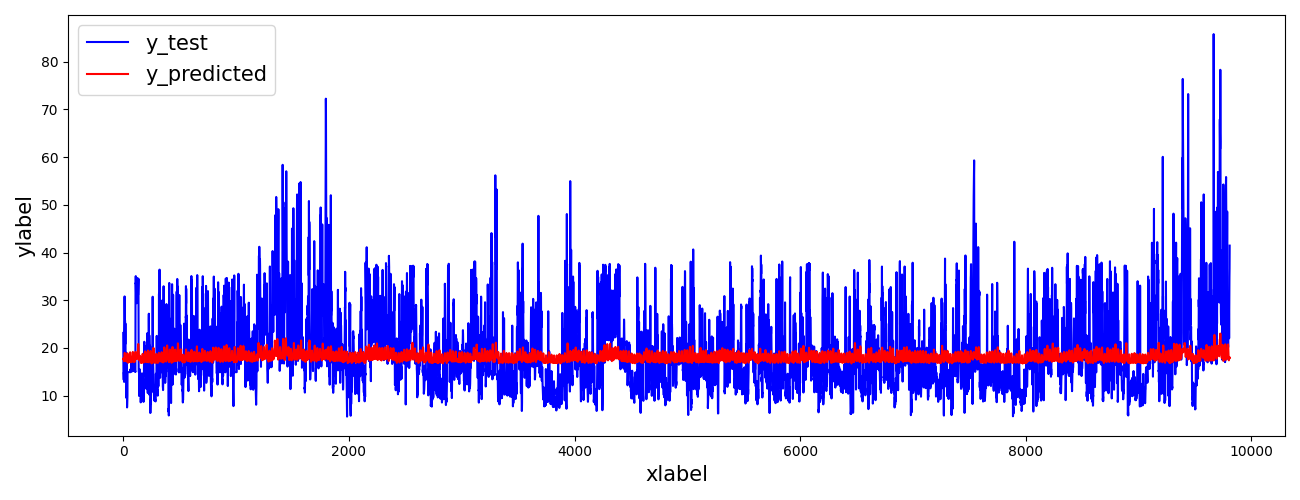

Day = 2
mae: 6.006505217088379
mse: 70.47766345579717
rmse: 8.395097584650054
r2: -189.20998672768417
mape: 0.3458450572461867
mnbe: -10.298789233580575
r_coeff: [0.32902213]


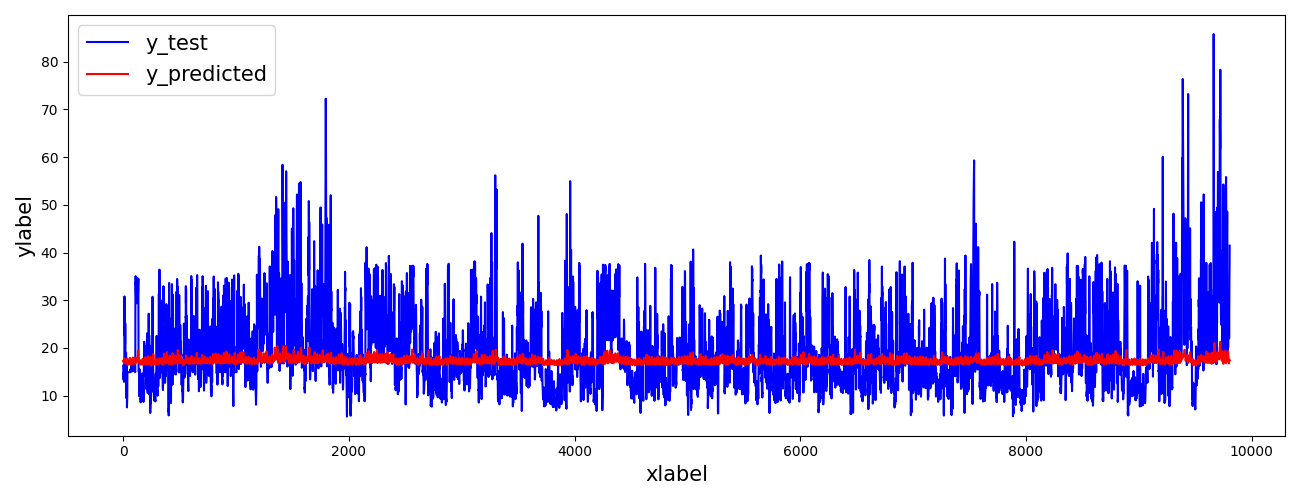

Day = 3
mae: 6.065943829463931
mse: 73.06462923498056
rmse: 8.547785048477795
r2: -342.5905270276993
mape: 0.35760660916510895
mnbe: -12.312669824698297
r_coeff: [0.29806892]


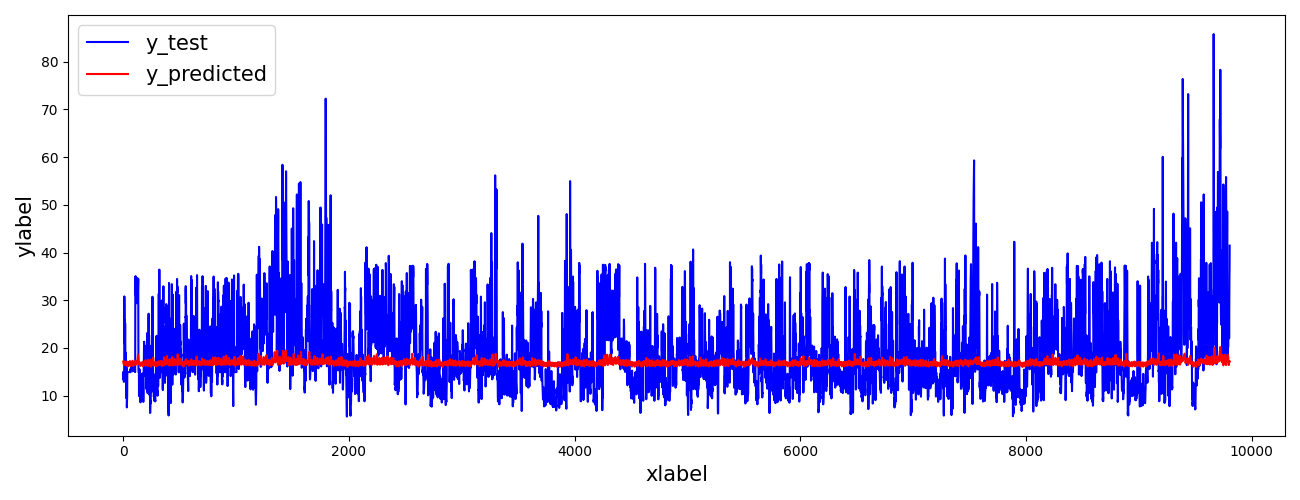

In [23]:
grus2s_shifted4 = define_grus2s_model(n_past, n_future,  X_train_shifted_4.shape[-1], y_train_shifted_4.shape[-1], "grus2s_shifted_4")

history = grus2s_shifted4.fit(X_train_shifted_4, y_train_shifted_4,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_4 = grus2s_shifted4.predict(X_test_shifted_4)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_4[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_4[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

In [24]:
stop

NameError: name 'stop' is not defined

### CNN-LSTM Seq2seq

In [ ]:
# Encoder layers
encoder_inputs = Input(shape=(n_past, n_features))
encoder_cnn_1 = Conv1D(filters=128, kernel_size=2, activation="relu")(encoder_inputs)
encoder_max_pooling_1 = MaxPooling1D(pool_size=2)(encoder_cnn_1)
encoder_cnn_2 = Conv1D(filters=64, kernel_size=2, activation="relu")(encoder_max_pooling_1)
encoder_max_pooling_2 = MaxPooling1D(pool_size=2)(encoder_cnn_2)
encoder_lstm, state_h, state_c = LSTM(64, return_state=True, activation="relu")(encoder_max_pooling_2)
encoder_dropout = Dropout(0.2)(encoder_lstm)
encoder_dense = Dense(latent_dim)(encoder_dropout)
# Repeat layer
decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
# Decoder layers
decoder_lstm_1 = LSTM(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=[state_h, state_c])
decoder_dropout = Dropout(0.2)(decoder_lstm_1)
decoder_outputs = TimeDistributed(Dense(n_label))(decoder_dropout)
# Compile the model
cnncnnlstms2smodel = Model(encoder_inputs, decoder_outputs)
# Compile the model
cnnlstms2smodel = Model(encoder_inputs, decoder_outputs)
cnnlstms2smodel.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
display(cnnlstms2smodel.summary())

# Fit model
history = cnnlstms2smodel.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    #EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = cnnlstms2smodel.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

## Evaluation board

In [ ]:
pd.DataFrame(evaluation_board)